In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [2]:
# visulization functions
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [3]:
class Config():
    training_dir = "../images_background"
    testing_dir = "../images_evaluation"
    train_batch_size = 64
    train_number_epochs = 100

In [4]:
# change folder structure
import os
class BatchRename():
    def __init__(self, path):
        self.path = path

    def rename(self):
        folderlist = os.listdir(self.path)
        for language in folderlist:
            print(language)
            character_path = os.path.join(self.path, language)
            for character in os.listdir(character_path):
                os.rename(os.path.join(character_path, character),
                    os.path.join(character_path, language + '_' + character))
                print('rename %s to %s' % (character, language + '_' + character))

In [5]:
# train = BatchRename("../images_background")
# train.rename()
# test = BatchRename("../images_evaluation")
# test.rename()
# bash command
    # cp -r images_evaluation/*/* images_evaluation
    # rm -rf images_evaluation/*[!0-9]

In [6]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        # make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                # keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            img1_tuple = random.choice(self.imageFolderDataset.imgs)

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        # 1: different class; 0: same class
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [7]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [8]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        # transform image from 105 to 100
                                        transform=transforms.Compose([transforms.Scale((100,100)),
                                                                      transforms.ToTensor()
                                                                     ])
                                       ,should_invert=False)

/home/aqz/anaconda2/lib/python2.7/site-packages/torchvision-0.2.0-py2.7.egg/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


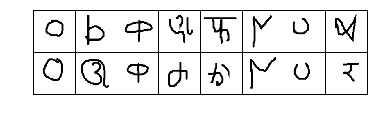

[[0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]]


In [9]:
# visulization
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)

example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
# check labels
print(example_batch[2].numpy())

In [10]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            nn.Dropout2d(p=.2),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),
        )
        # fully connection
        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [11]:
# define loss function
class ContrastiveLoss(torch.nn.Module):

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

In [12]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [13]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005)

In [14]:
counter = []
loss_history = [] 
iteration_number= 0

Epoch number 0
 Current loss 1.6090003252

Epoch number 0
 Current loss 0.779991209507

Epoch number 1
 Current loss 0.819159388542

Epoch number 1
 Current loss 0.631886899471

Epoch number 2
 Current loss 0.822015166283

Epoch number 2
 Current loss 0.602081775665

Epoch number 3
 Current loss 0.637717843056

Epoch number 3
 Current loss 0.631477594376

Epoch number 4
 Current loss 0.504081249237

Epoch number 4
 Current loss 0.516984581947

Epoch number 5
 Current loss 0.53270471096

Epoch number 5
 Current loss 0.647675156593

Epoch number 6
 Current loss 0.531161725521

Epoch number 6
 Current loss 0.58474445343

Epoch number 7
 Current loss 0.470080375671

Epoch number 7
 Current loss 0.476211369038

Epoch number 8
 Current loss 0.439302712679

Epoch number 8
 Current loss 0.448023170233

Epoch number 9
 Current loss 0.4623721838

Epoch number 9
 Current loss 0.499716758728

Epoch number 10
 Current loss 0.408423393965

Epoch number 10
 Current loss 0.524482488632

Epoch number 1

Epoch number 89
 Current loss 0.105254814029

Epoch number 90
 Current loss 0.0886662006378

Epoch number 90
 Current loss 0.132211446762

Epoch number 91
 Current loss 0.11089386791

Epoch number 91
 Current loss 0.14040376246

Epoch number 92
 Current loss 0.141471609473

Epoch number 92
 Current loss 0.126054048538

Epoch number 93
 Current loss 0.14853054285

Epoch number 93
 Current loss 0.102759040892

Epoch number 94
 Current loss 0.0993301421404

Epoch number 94
 Current loss 0.141270473599

Epoch number 95
 Current loss 0.0866012349725

Epoch number 95
 Current loss 0.101967521012

Epoch number 96
 Current loss 0.154236882925

Epoch number 96
 Current loss 0.19158244133

Epoch number 97
 Current loss 0.112515248358

Epoch number 97
 Current loss 0.105104282498

Epoch number 98
 Current loss 0.0628928393126

Epoch number 98
 Current loss 0.119519300759

Epoch number 99
 Current loss 0.121805928648

Epoch number 99
 Current loss 0.141503557563



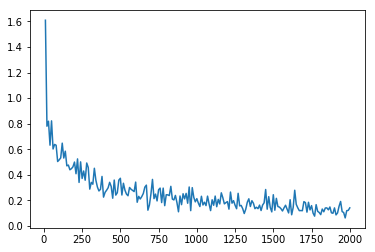

In [15]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0): # data = torch.FloatTensor 64*1*100*100
        img0, img1, label = data
        img0, img1, label = Variable(img0).cuda(), Variable(img1).cuda(), Variable(label).cuda()
        output1,output2 = net(img0,img1)
        optimizer.zero_grad()
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward() # loss backward, update parameters
        optimizer.step()
        if i % 300 == 0:
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.data[0]))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.data[0])
show_plot(counter,loss_history)

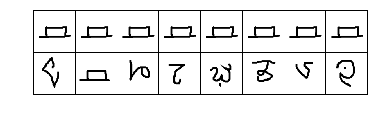

[[1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]]
Variable containing:
 2.4078
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]

Variable containing:
 0.7048
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]

Variable containing:
 1.9873
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]

Variable containing:
 4.0732
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]

Variable containing:
 1.8450
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]

Variable containing:
 3.0114
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]

Variable containing:
 1.9550
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]

Variable containing:
 2.8857
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]



In [36]:
vis_test_dataloader = DataLoader(siamese_dataset,
                        shuffle=False,
                        num_workers=8,
                        batch_size=8)
test_dataiter = iter(vis_test_dataloader)

example_batch = next(test_dataiter)
img = example_batch[0][1]
for i in range(8):
    example_batch[0][i] = img
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))

for i, j in zip(example_batch[0], example_batch[1]):
    i.unsqueeze_(0)
    j.unsqueeze_(0)
    output1,output2 = net(Variable(i).cuda(),Variable(j).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    print(euclidean_distance)

In [46]:
a = euclidean_distance.data.cpu().numpy().flatten()[0]
a

2.8857033

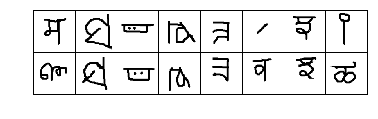

[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]]
Variable containing:
 2.9695
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]

Variable containing:
 0.4364
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]

Variable containing:
 0.5792
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]

Variable containing:
 1.4615
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]

Variable containing:
 0.6269
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]

Variable containing:
 2.7317
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]

Variable containing:
 1.6866
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]

Variable containing:
 4.1701
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]



In [23]:
vis_test_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
test_dataiter = iter(vis_test_dataloader)

example_batch = next(test_dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
# labels
print(example_batch[2].numpy())

for i, j in zip(example_batch[0], example_batch[1]):
    i.unsqueeze_(0)
    j.unsqueeze_(0)
    output1,output2 = net(Variable(i).cuda(),Variable(j).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    print(euclidean_distance)

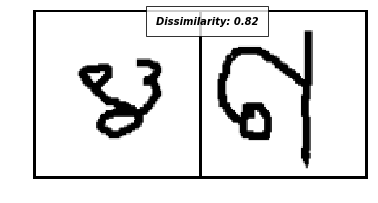

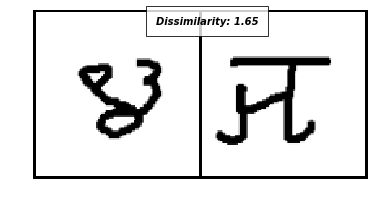

In [57]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Scale((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=False)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)
for i in range(2):
    _,x1,_ = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.cpu().data.numpy()[0][0]))

In [47]:
import copy
from matplotlib.pyplot import imread
from skimage.transform import resize

# Parameters
nrun = 20 # number of classification runs
fname_label = 'class_labels.txt' # where class labels are stored for each run

In [64]:
def classification_run(folder,f_load,f_cost,ftype='cost'):
    # Compute error rate for one run of one-shot classification
    #
    # Input
    #  folder : contains images for a run of one-shot classification
    #  f_load : itemA = f_load('file.png') should read in the image file and process it
    #  f_cost : f_cost(itemA,itemB) should compute similarity between two images, using output of f_load
    #  ftype  : 'cost' if small values from f_cost mean more similar, or 'score' if large values are more similar
    #
    # Output
    #  perror : percent errors (0 to 100% error)
    # 
    assert ((ftype=='cost') | (ftype=='score'))

    # get file names
    with open(folder+'/'+fname_label) as f:
        content = f.read().splitlines()
    pairs = [line.split() for line in content]
    test_files  = [pair[0] for pair in pairs]
    train_files = [pair[1] for pair in pairs]
    answers_files = copy.copy(train_files)
    test_files.sort()
    train_files.sort()
    ntrain = len(train_files)
    ntest = len(test_files)

    # load the images (and, if needed, extract features)
    train_items = [f_load(f) for f in train_files]
    test_items  = [f_load(f) for f in test_files ]

    # compute cost matrix
    costM = np.zeros((ntest,ntrain),float)
    for i in range(ntest):
        for c in range(ntrain):
            costM[i,c] = f_cost(test_items[i],train_items[c])
            
            a = torch.from_numpy(test_items[i])
            b = torch.from_numpy(test_items[c])
            concatenated = torch.cat((a,b),0)
            imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(costM[i,c]))
            break
    if ftype == 'cost':
        YHAT = np.argmin(costM,axis=1)
    elif ftype == 'score':
        YHAT = np.argmax(costM,axis=1)
    else:
        assert False

    # compute the error rate
    correct = 0.0
    for i in range(ntest):
        if train_files[YHAT[i]] == answers_files[i]:
            correct += 1.0
    pcorrect = 100 * correct / ntest
    perror = 100 - pcorrect
    return perror

In [62]:
def LoadImgs(fn):
    I = imread(fn)
    I = resize(I, (100,100))
    return I.reshape(-1,1,100,100).astype('float')

In [54]:
def Distance(x0,x1):
    x0 = torch.from_numpy(x0).float()
    x1 = torch.from_numpy(x1).float()
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    return euclidean_distance.data.cpu().numpy().flatten()[0]

One-shot classification demo with Modified Hausdorff Distance


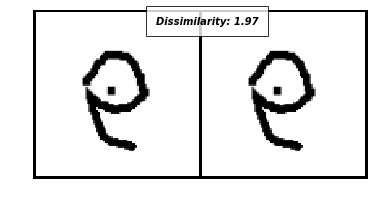

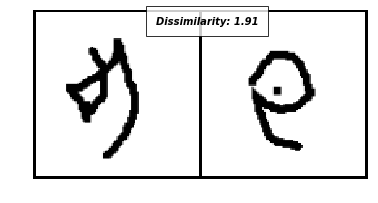

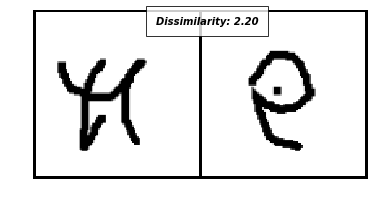

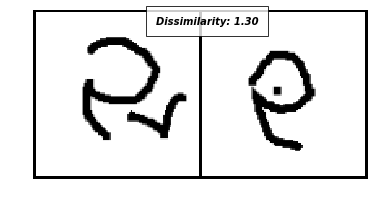

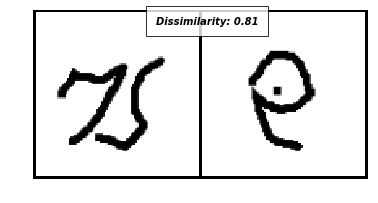

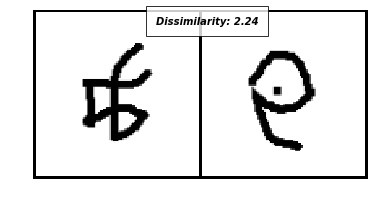

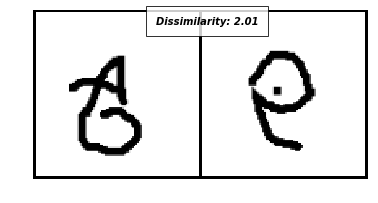

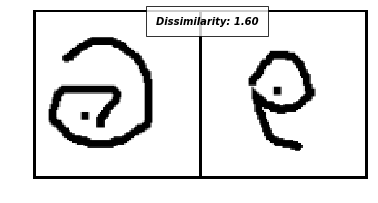

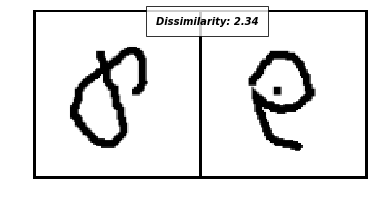

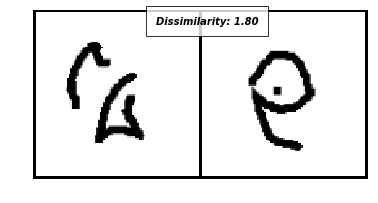

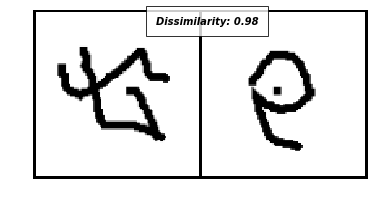

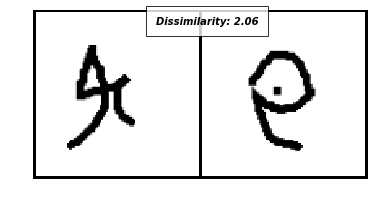

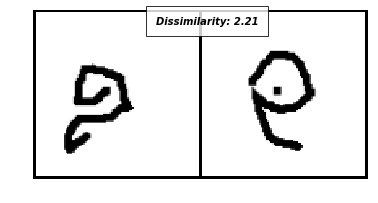

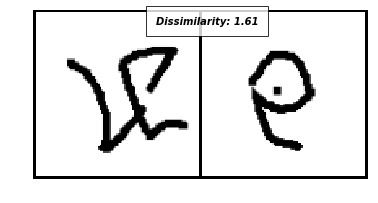

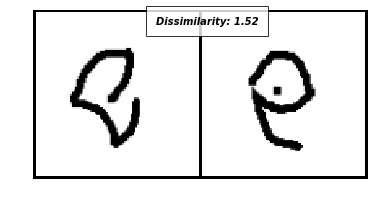

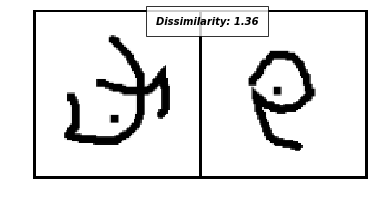

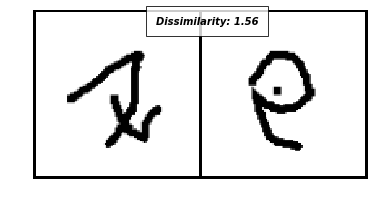

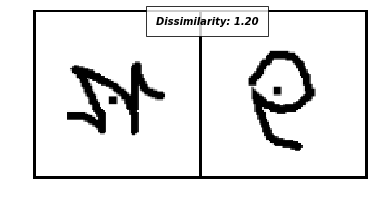

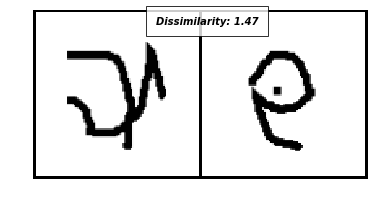

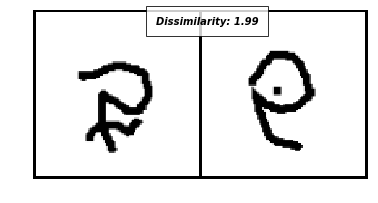

 run 1 (error 95.0%)


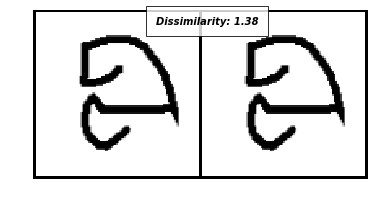

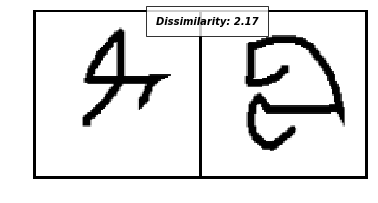

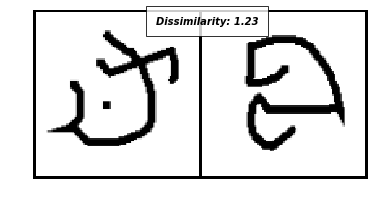

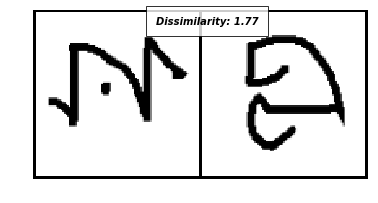

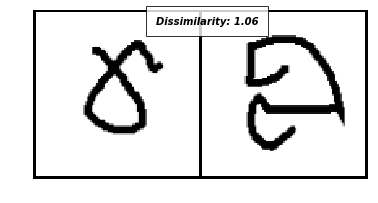

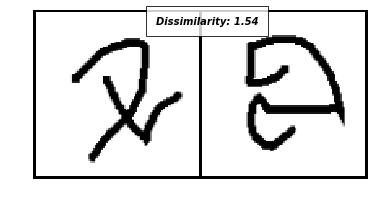

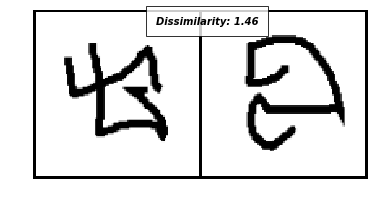

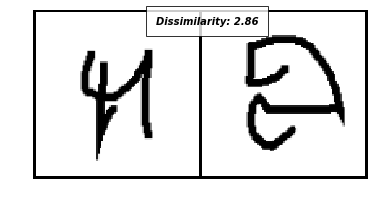

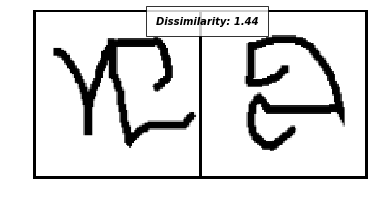

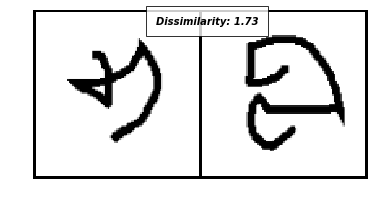

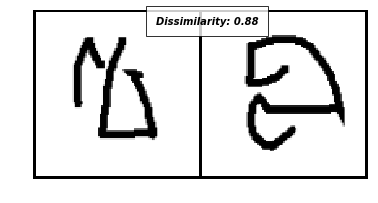

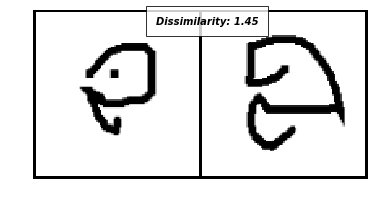

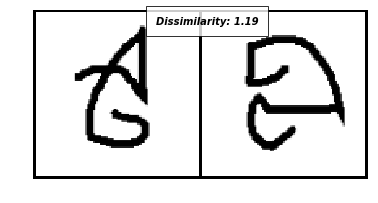

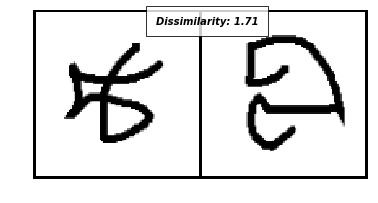

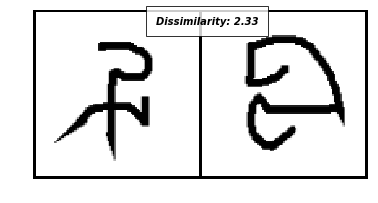

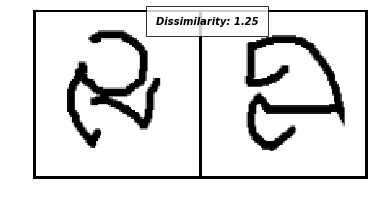

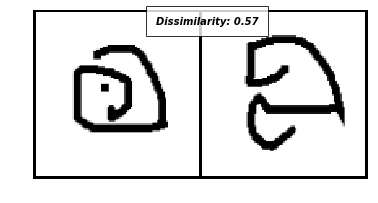

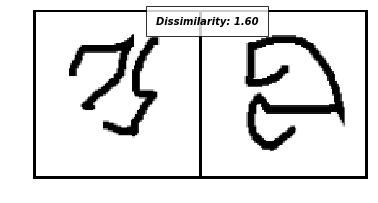

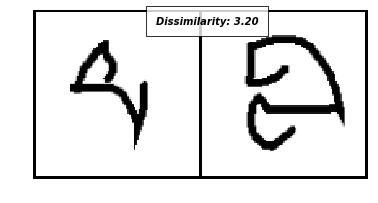

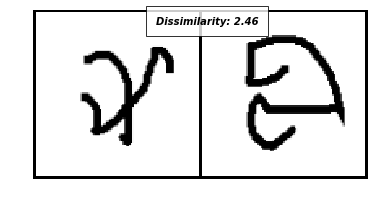

 run 2 (error 95.0%)


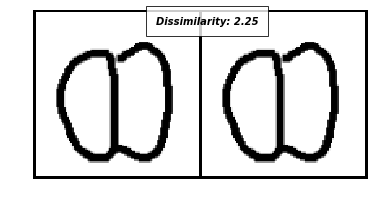

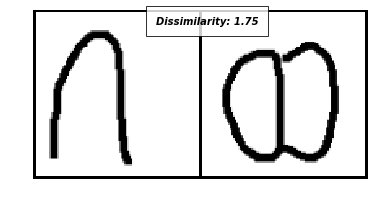

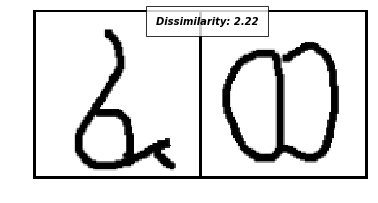

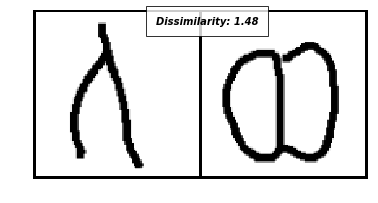

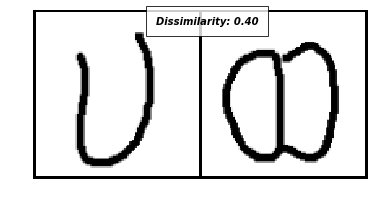

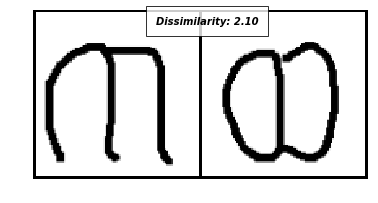

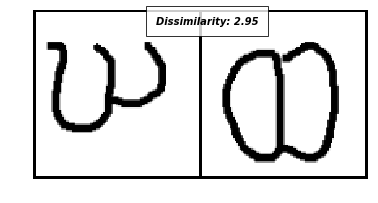

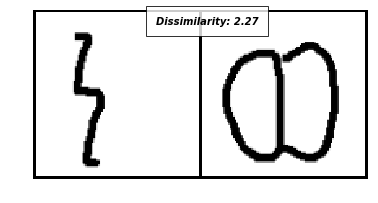

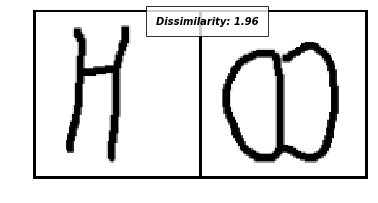

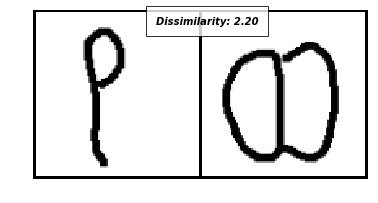

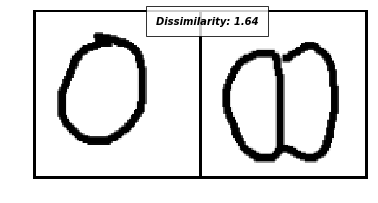

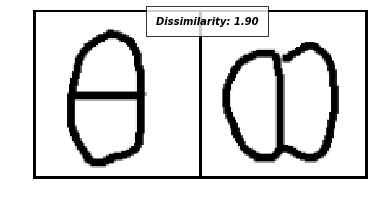

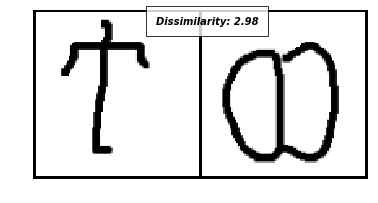

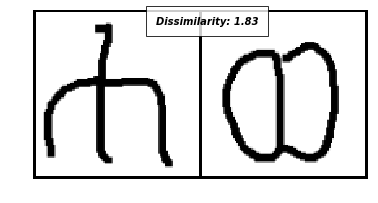

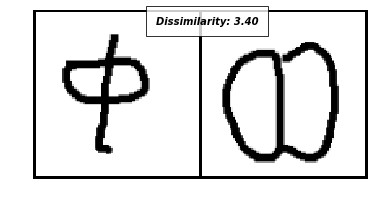

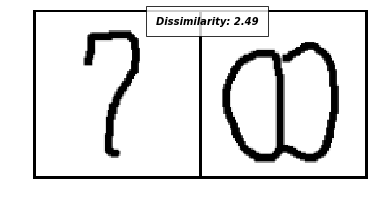

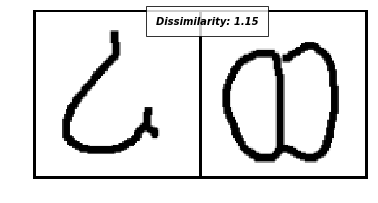

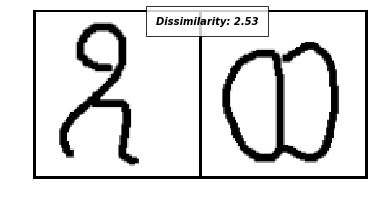

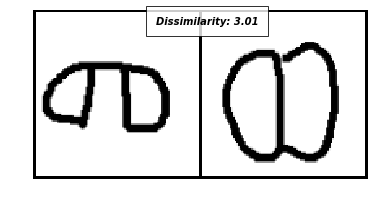

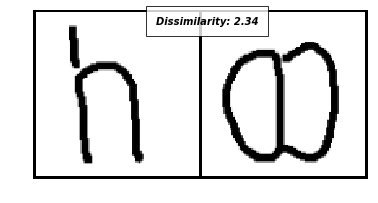

 run 3 (error 95.0%)


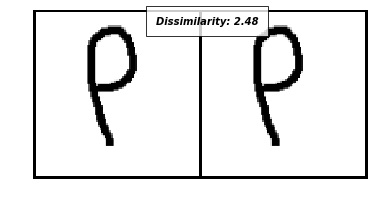

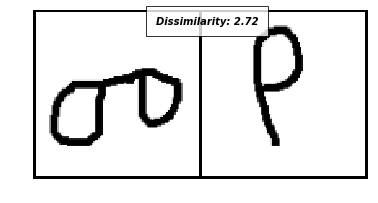

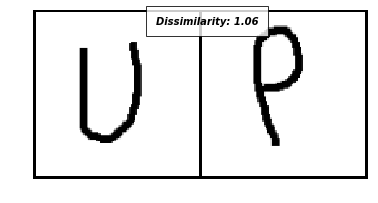

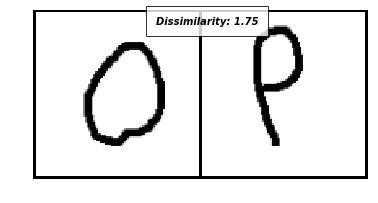

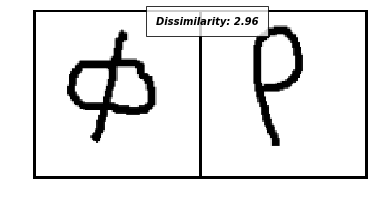

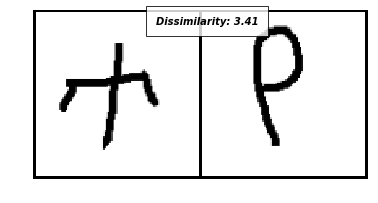

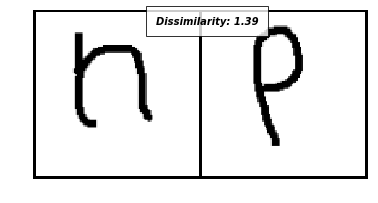

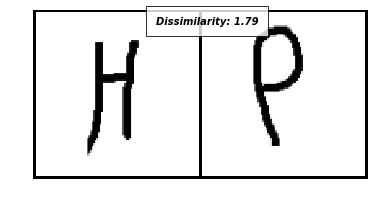

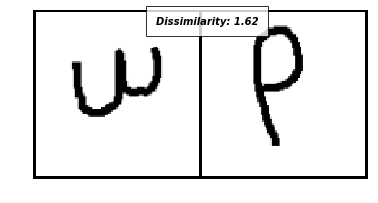

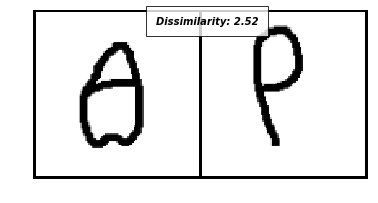

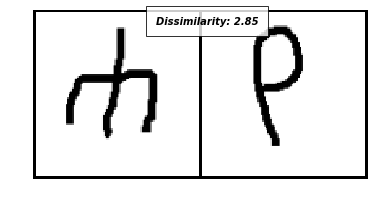

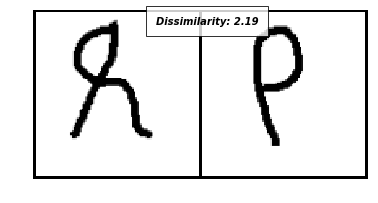

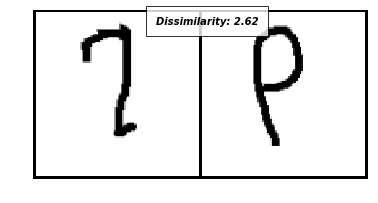

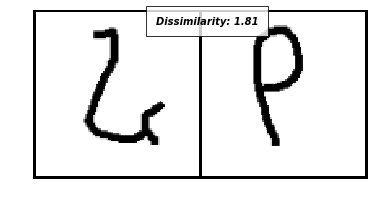

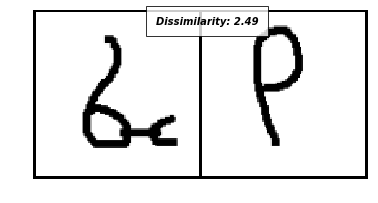

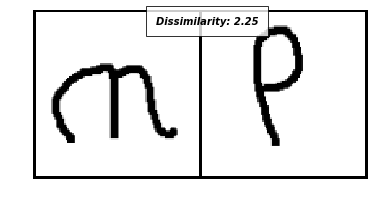

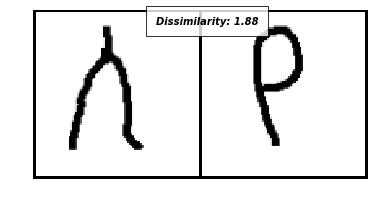

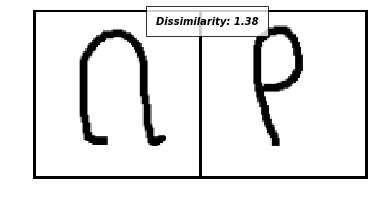

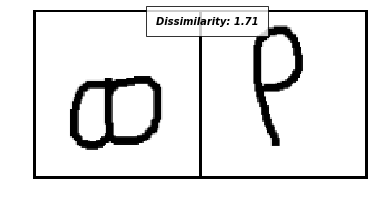

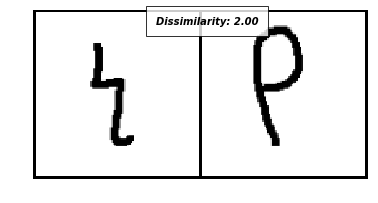

 run 4 (error 95.0%)


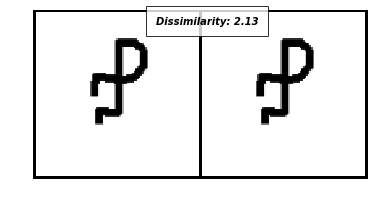

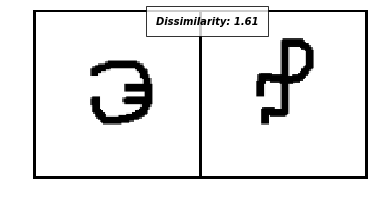

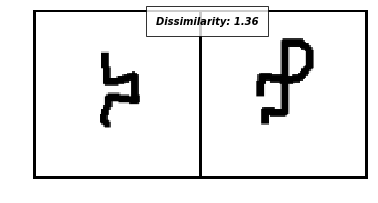

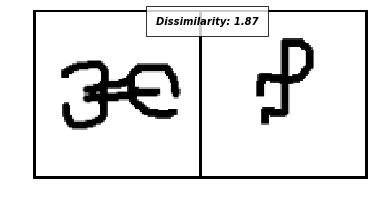

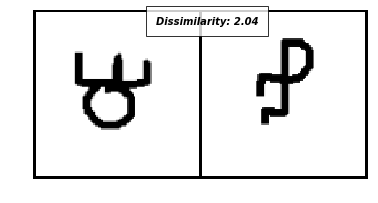

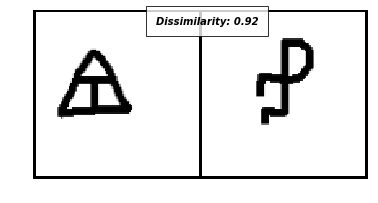

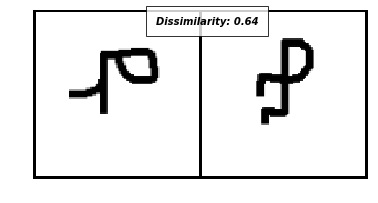

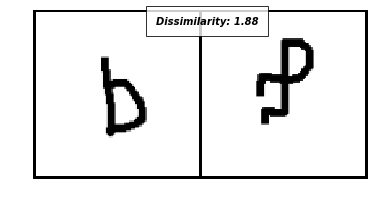

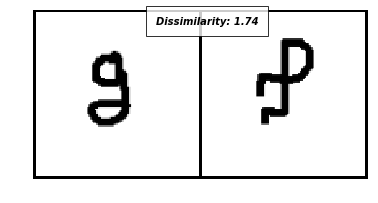

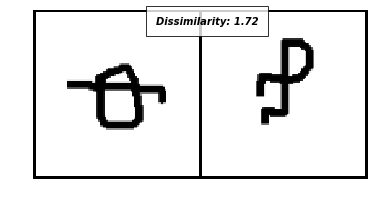

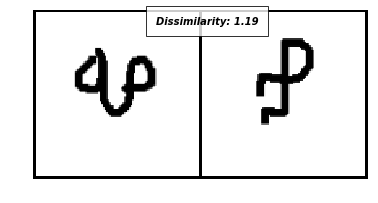

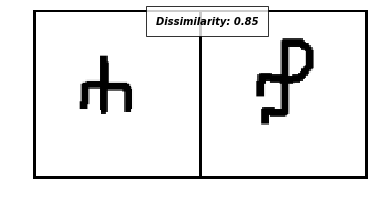

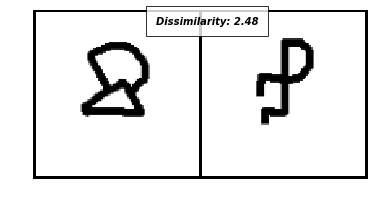

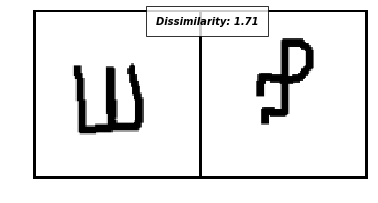

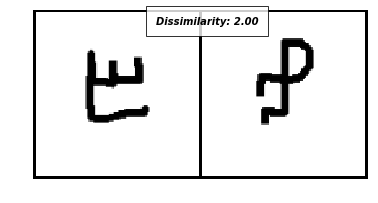

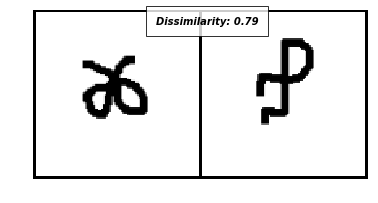

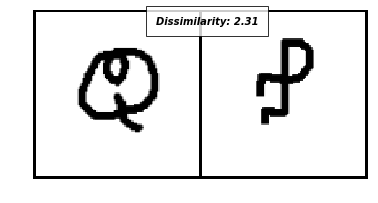

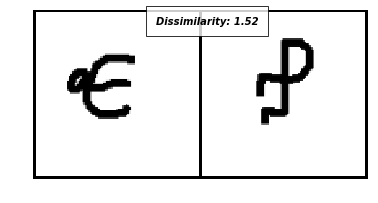

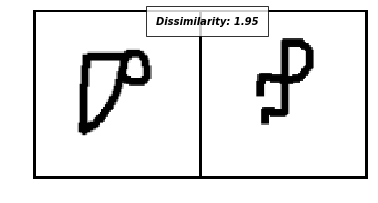

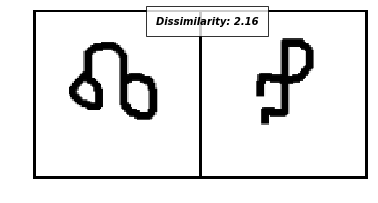

 run 5 (error 95.0%)


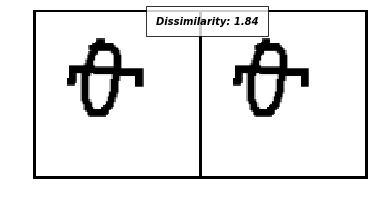

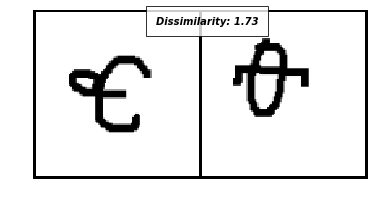

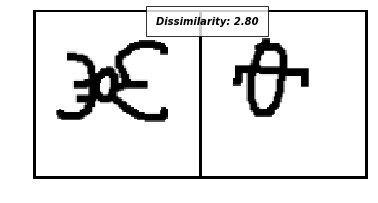

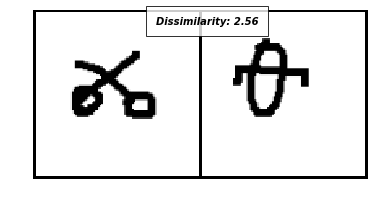

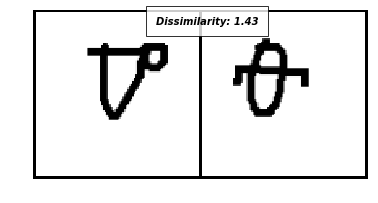

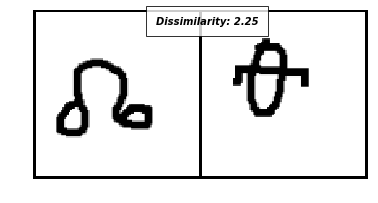

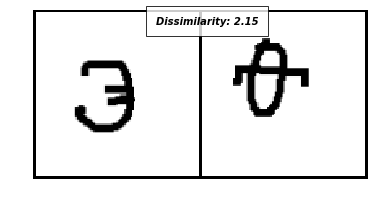

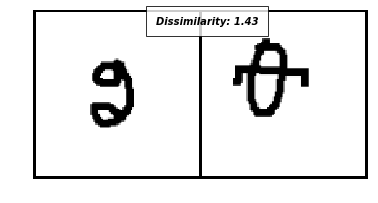

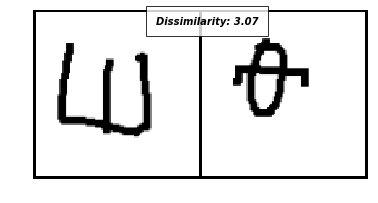

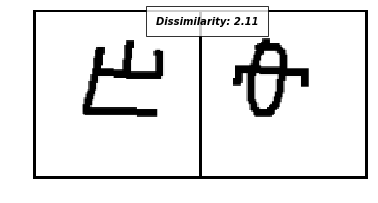

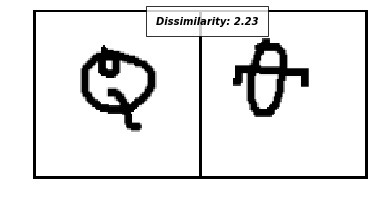

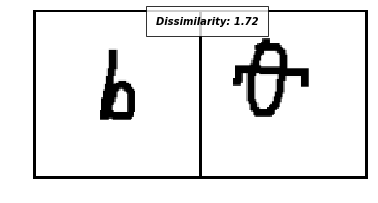

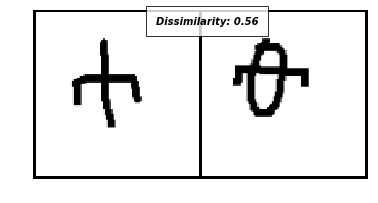

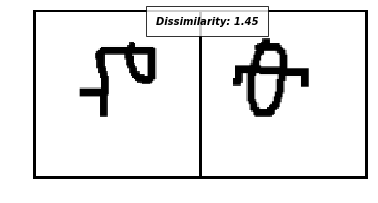

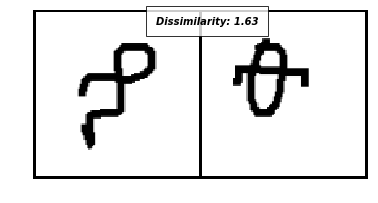

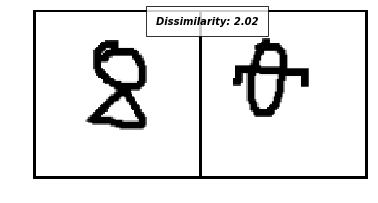

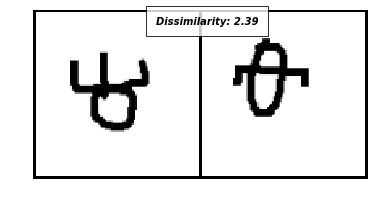

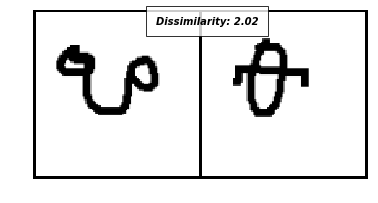

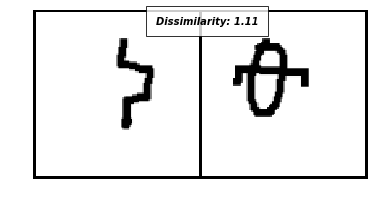

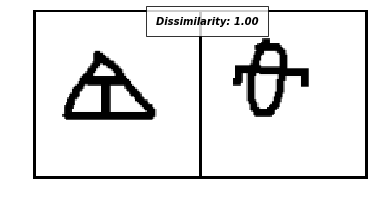

 run 6 (error 95.0%)


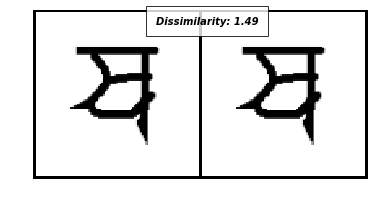

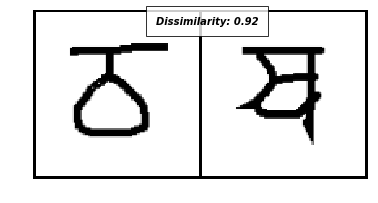

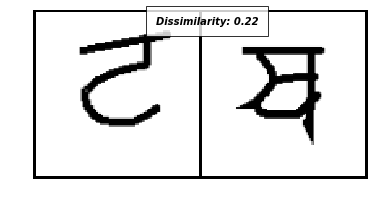

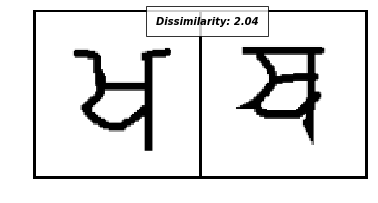

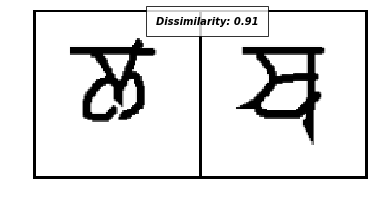

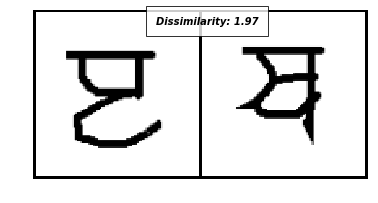

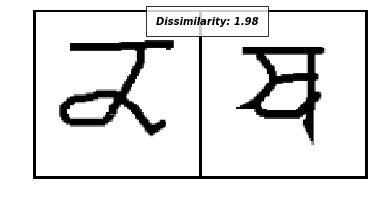

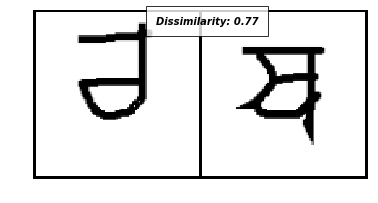

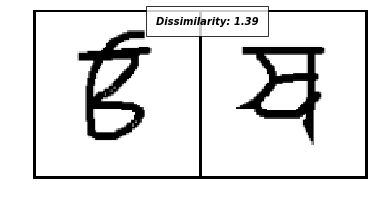

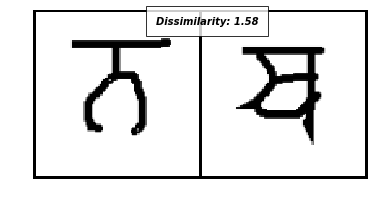

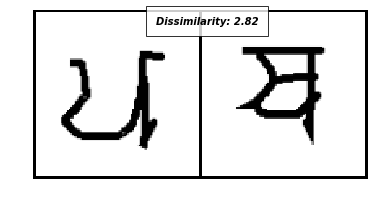

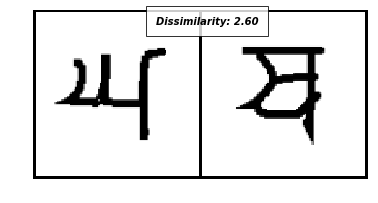

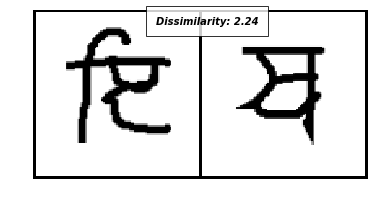

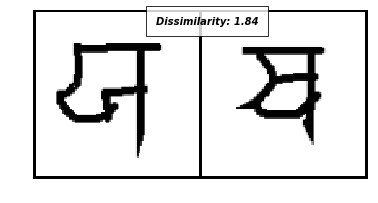

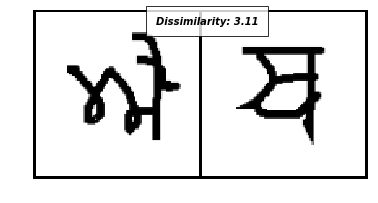

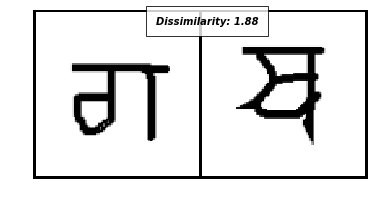

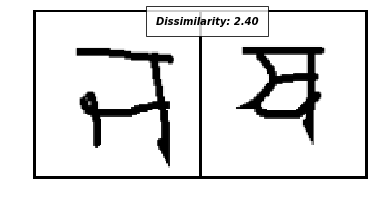

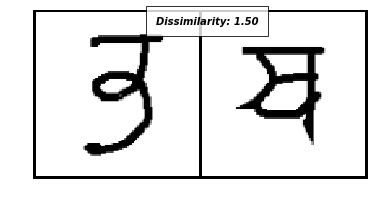

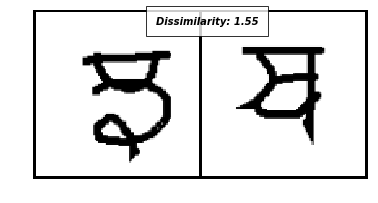

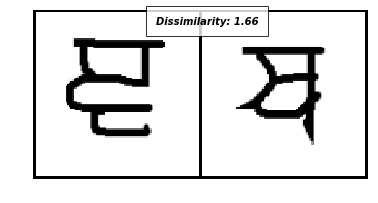

 run 7 (error 95.0%)


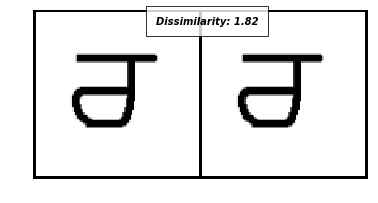

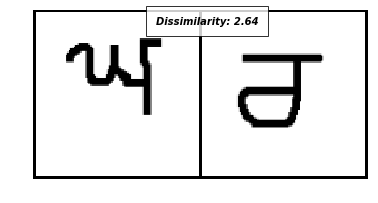

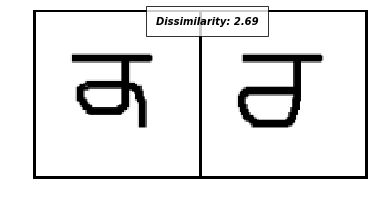

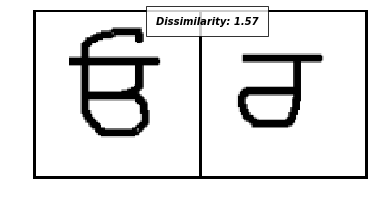

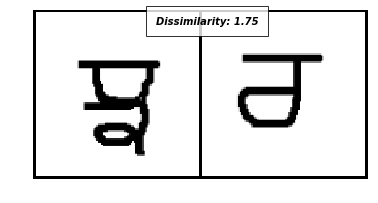

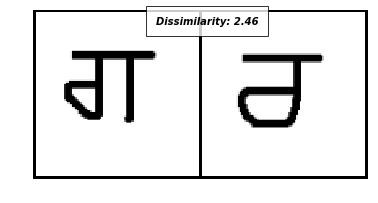

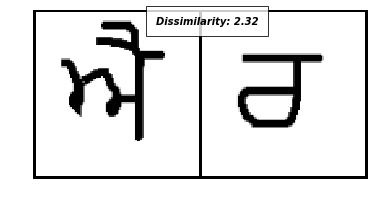

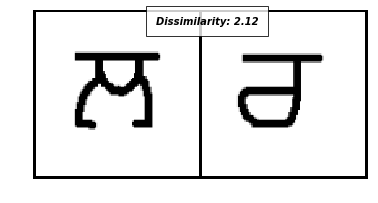

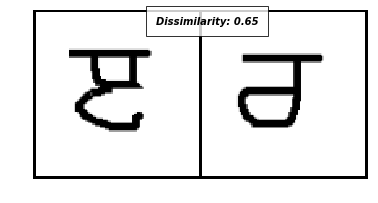

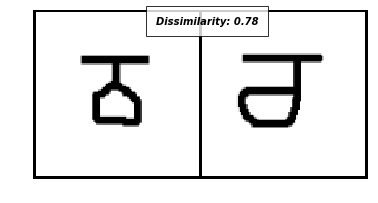

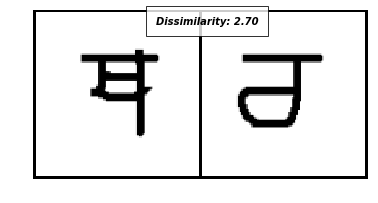

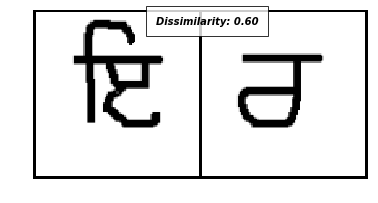

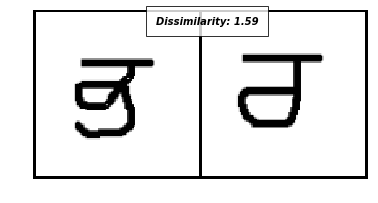

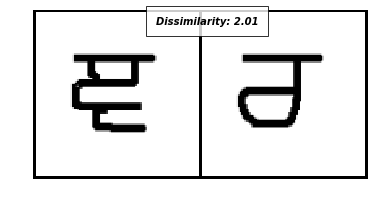

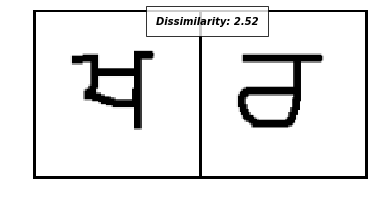

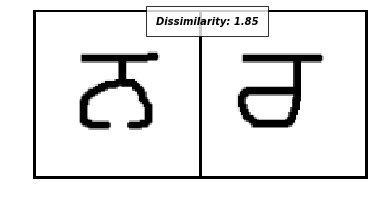

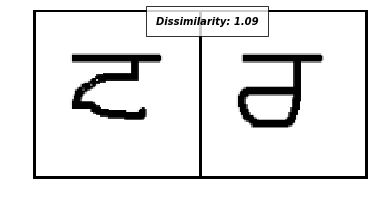

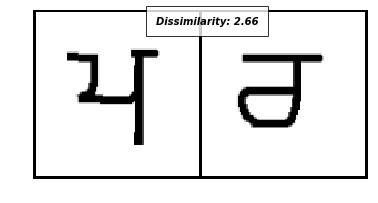

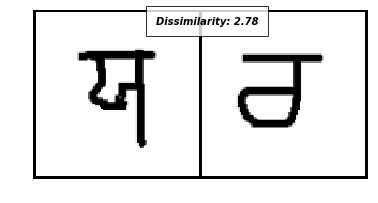

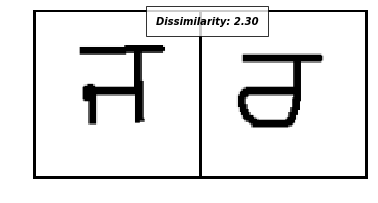

 run 8 (error 95.0%)


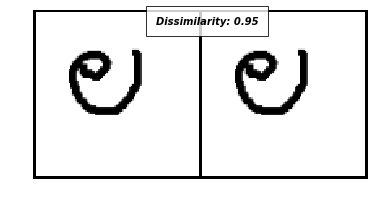

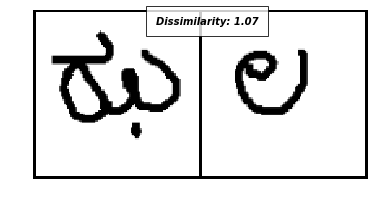

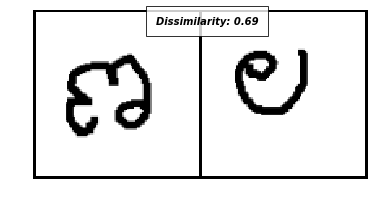

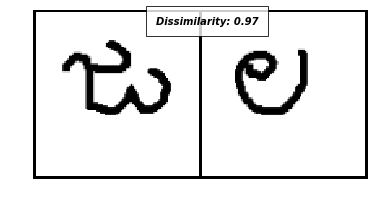

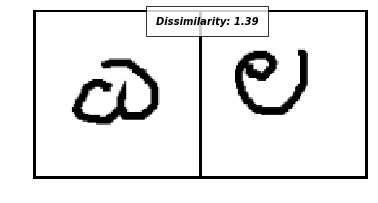

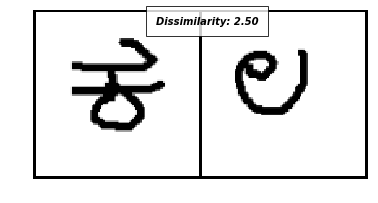

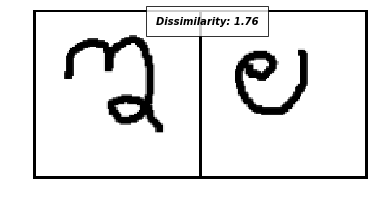

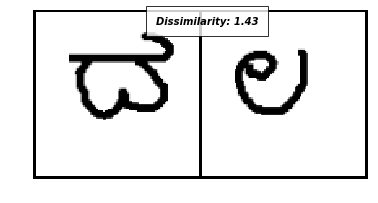

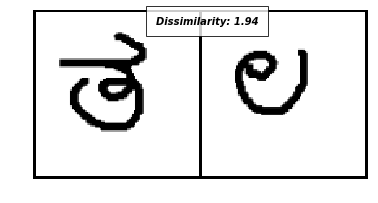

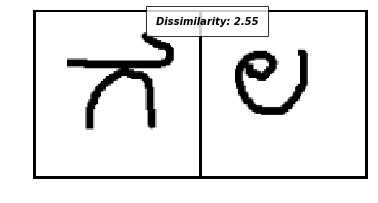

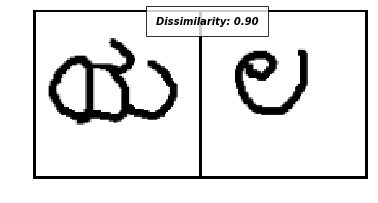

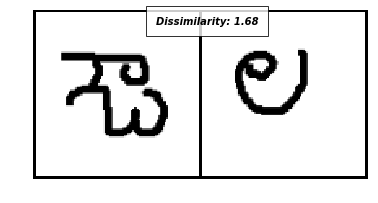

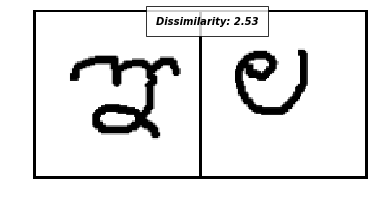

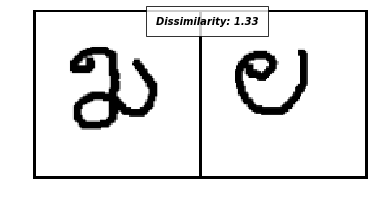

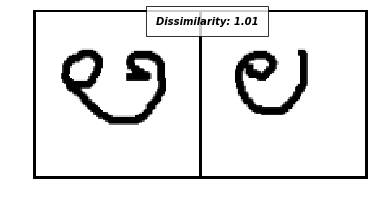

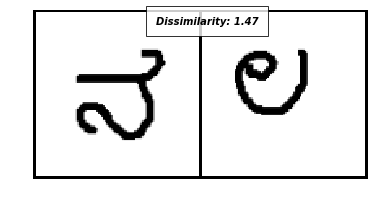

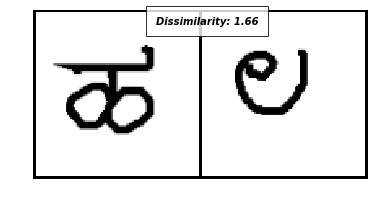

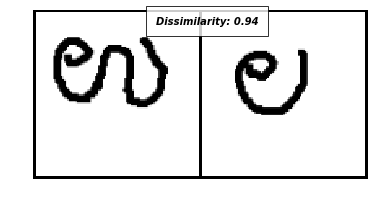

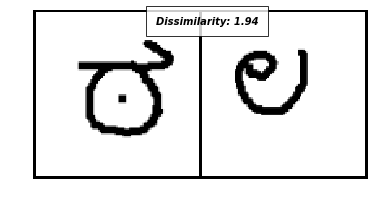

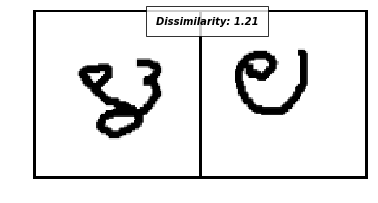

 run 9 (error 95.0%)


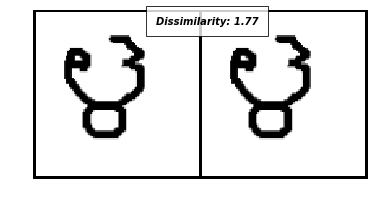

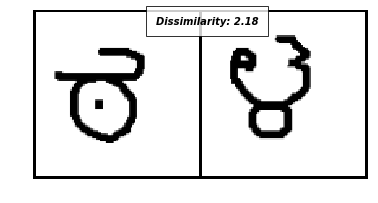

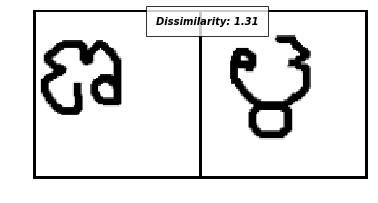

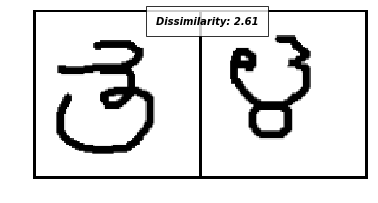

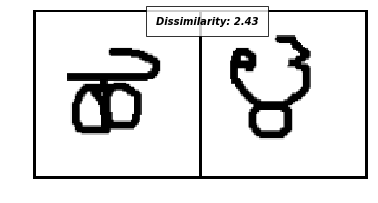

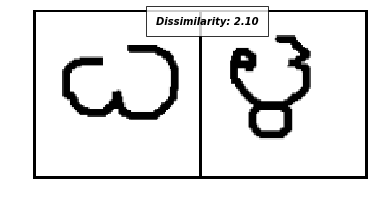

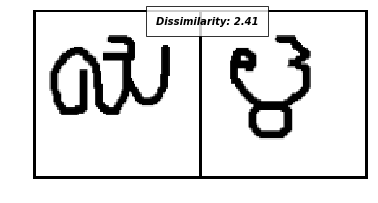

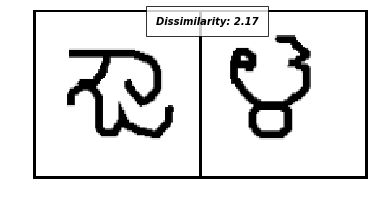

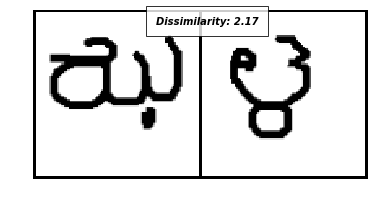

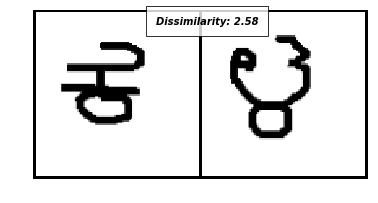

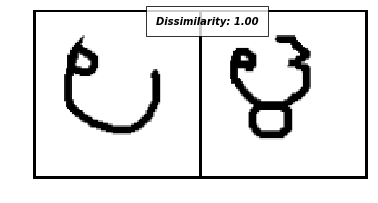

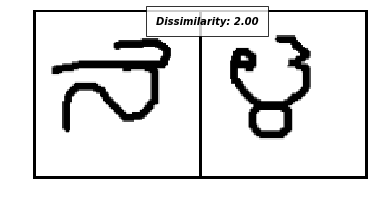

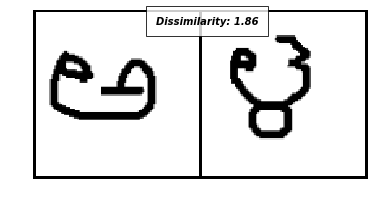

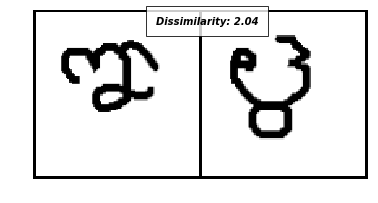

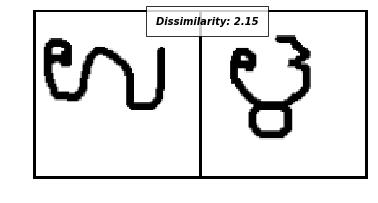

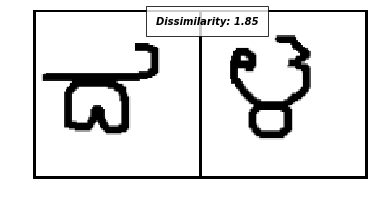

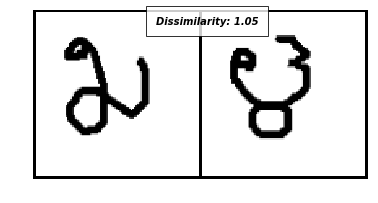

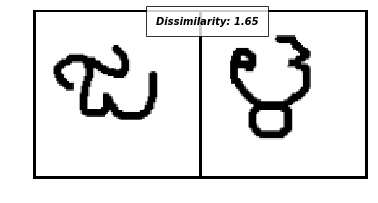

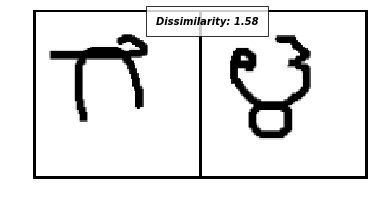

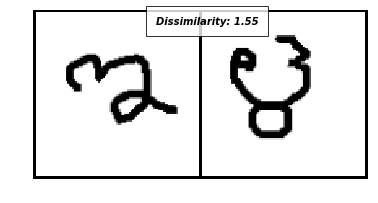

 run 10 (error 95.0%)


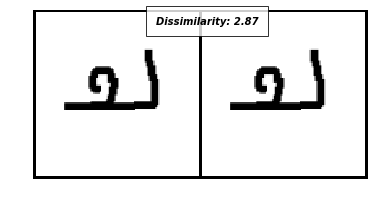

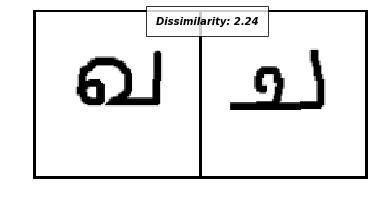

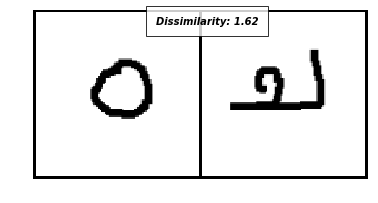

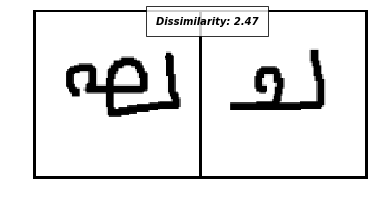

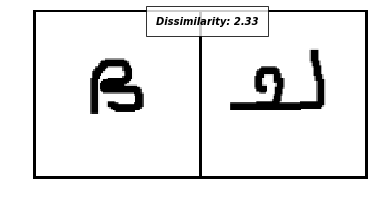

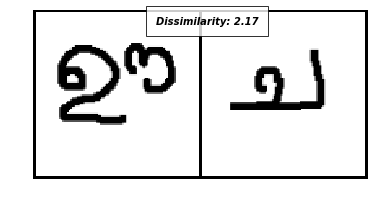

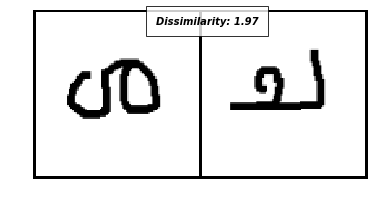

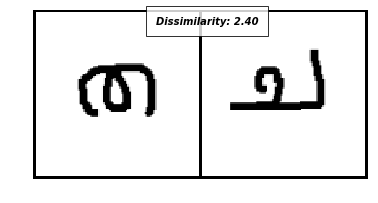

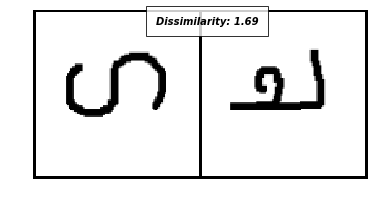

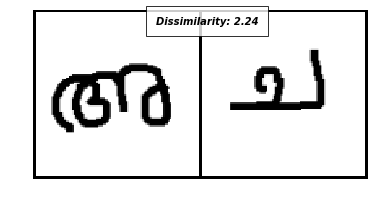

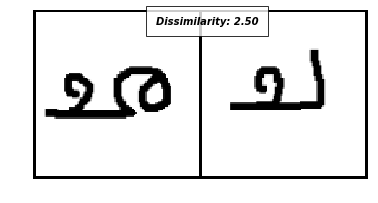

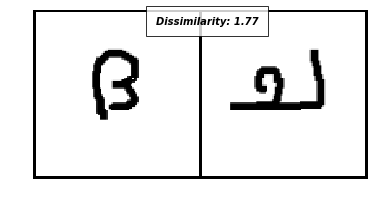

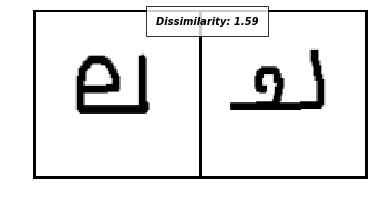

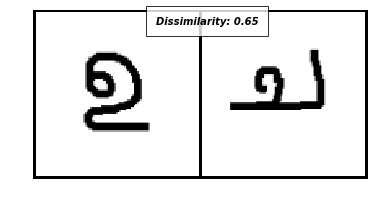

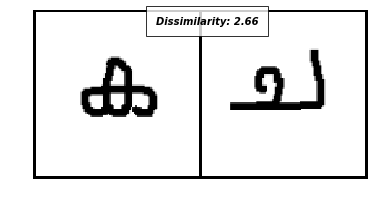

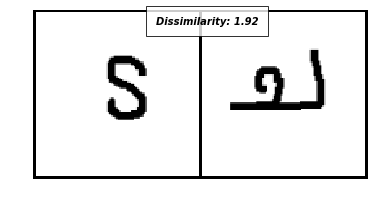

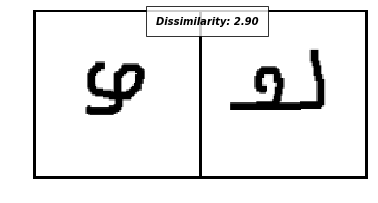

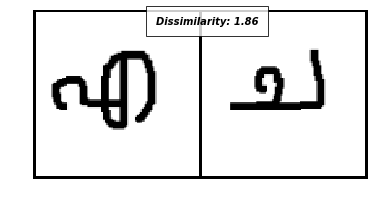

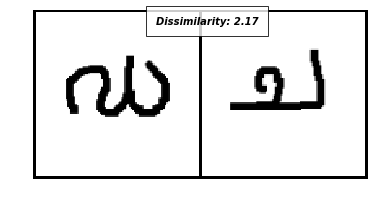

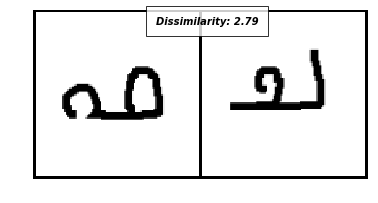

 run 11 (error 95.0%)


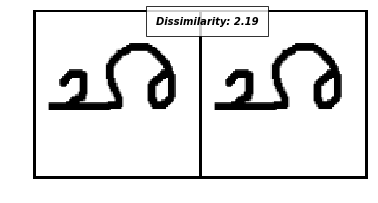

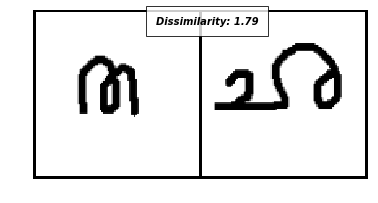

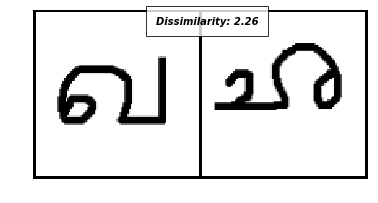

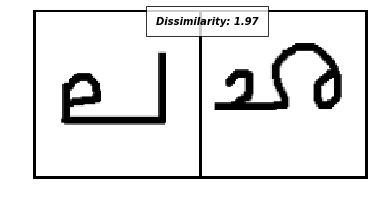

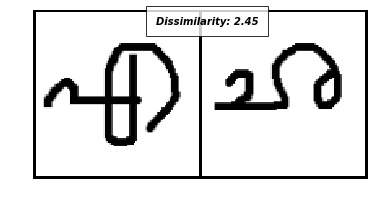

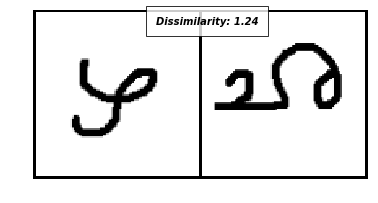

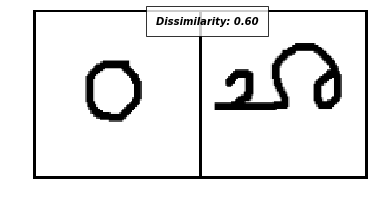

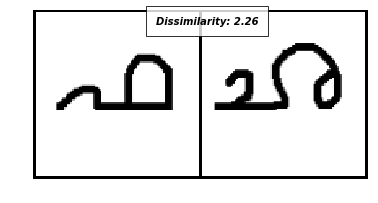

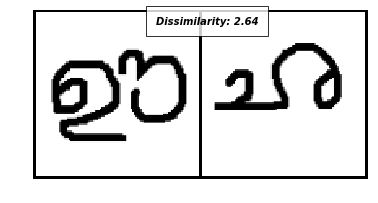

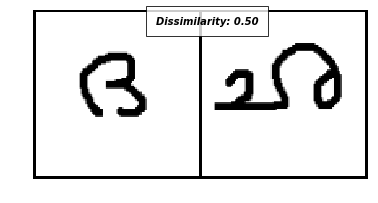

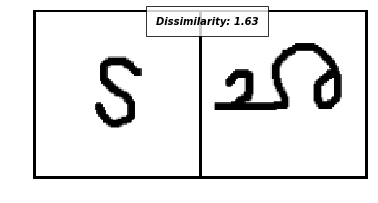

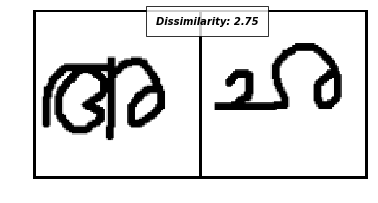

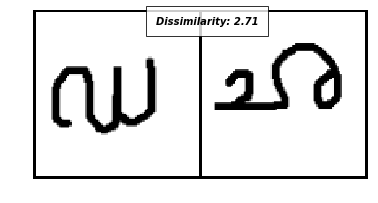

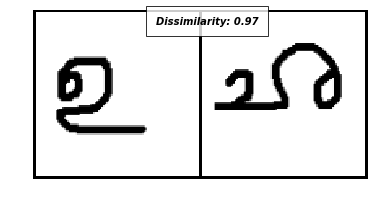

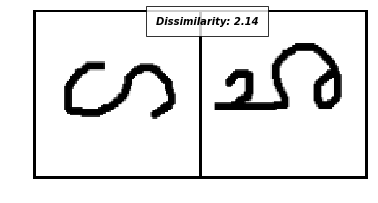

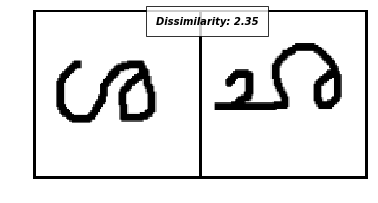

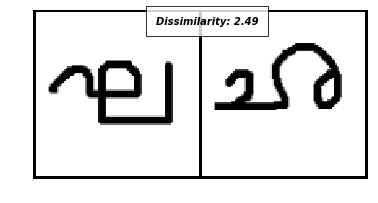

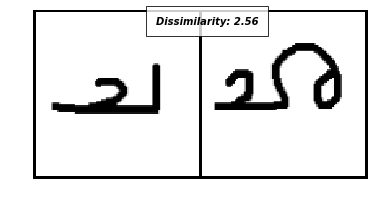

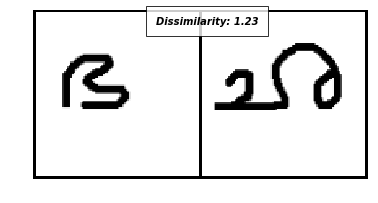

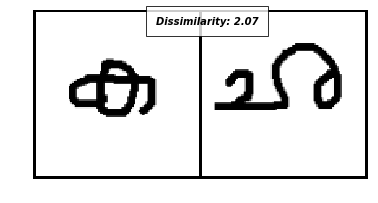

 run 12 (error 95.0%)


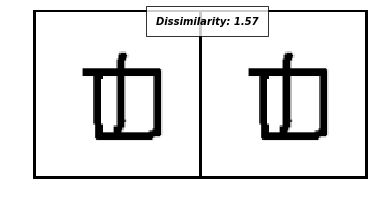

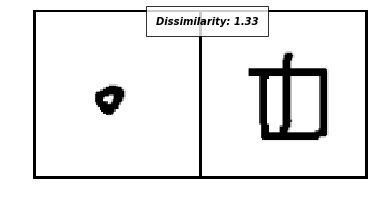

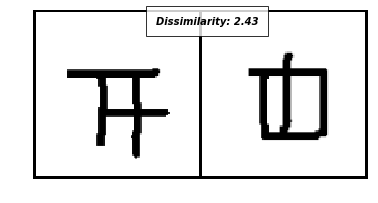

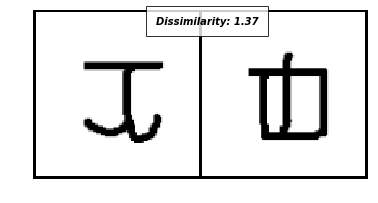

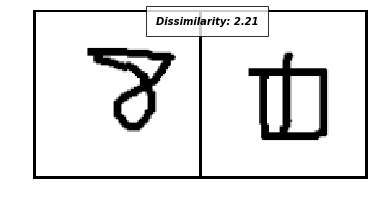

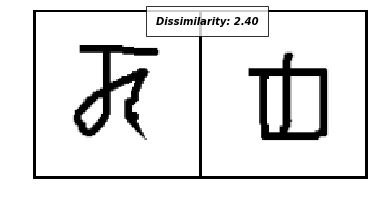

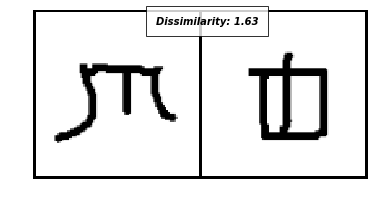

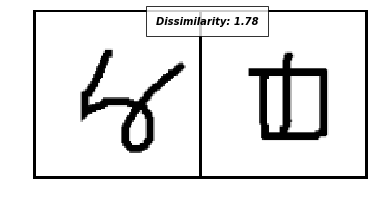

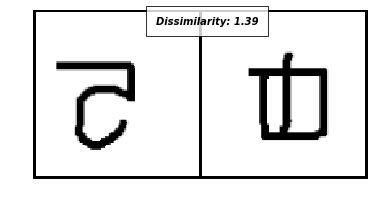

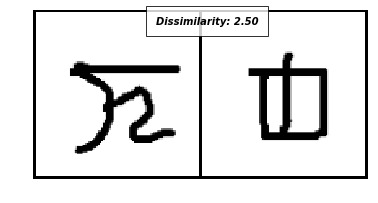

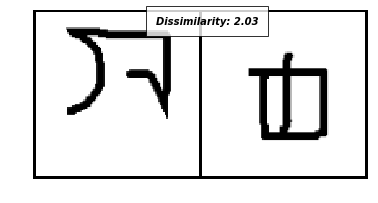

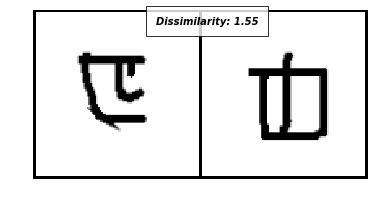

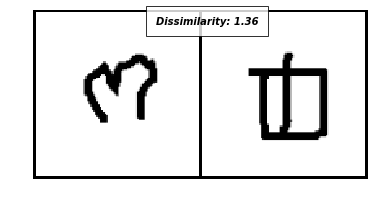

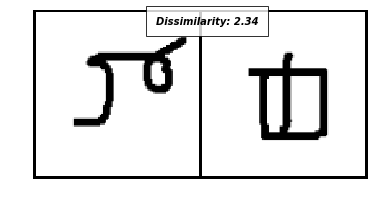

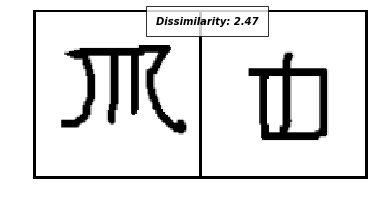

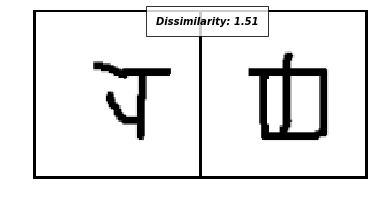

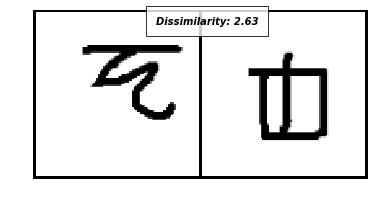

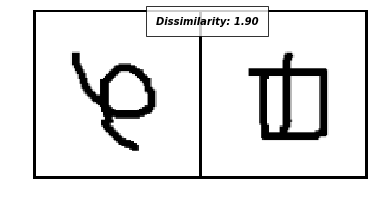

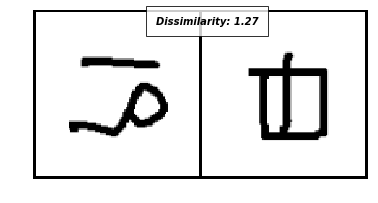

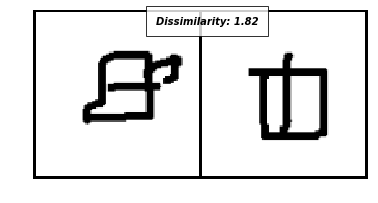

 run 13 (error 95.0%)


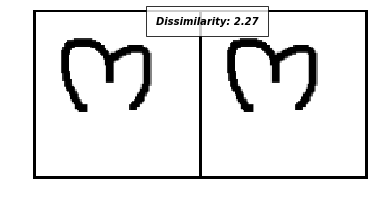

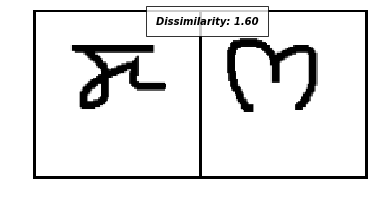

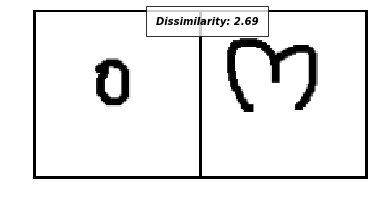

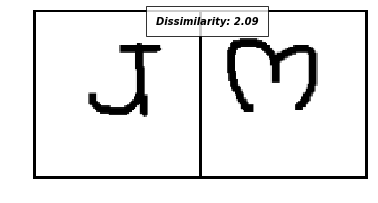

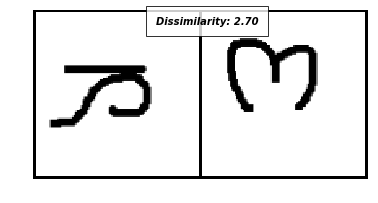

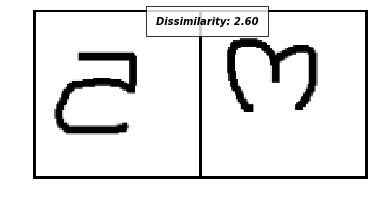

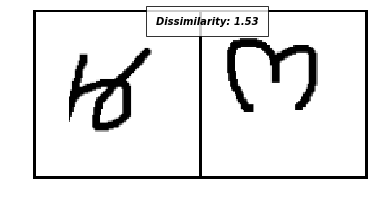

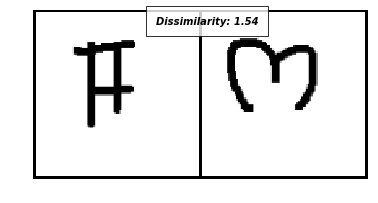

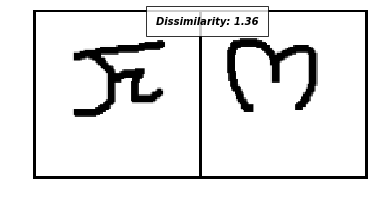

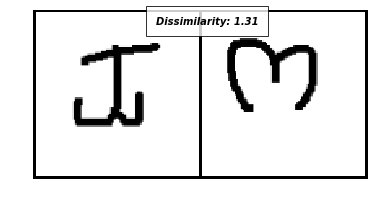

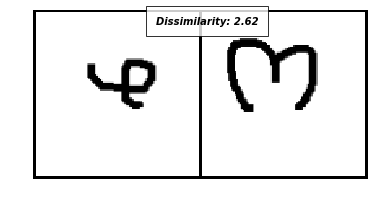

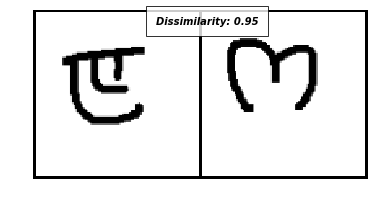

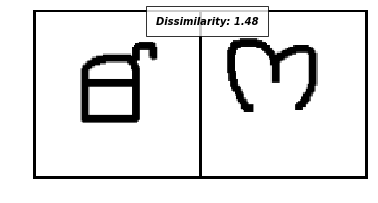

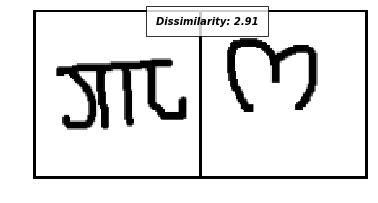

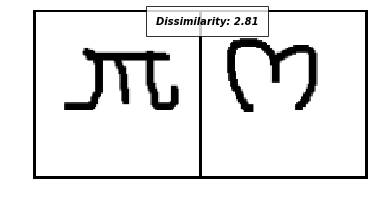

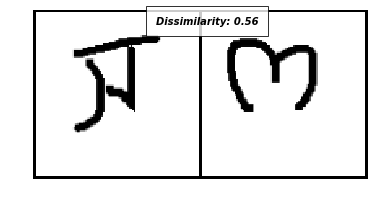

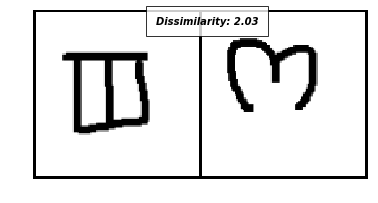

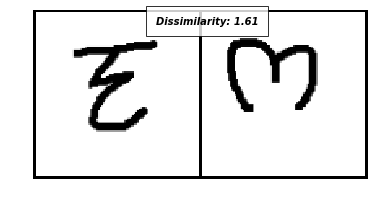

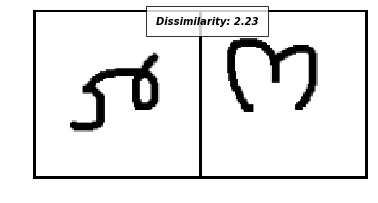

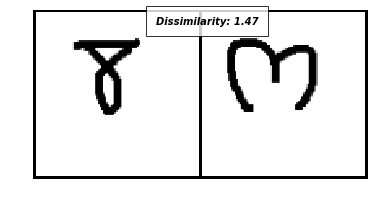

 run 14 (error 95.0%)


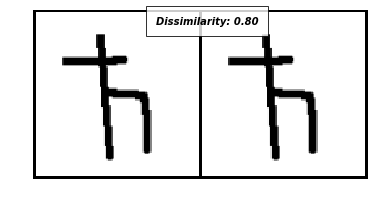

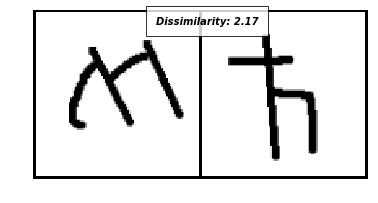

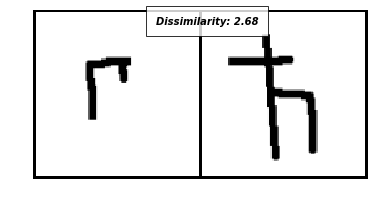

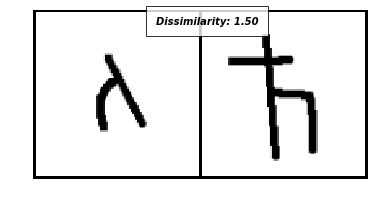

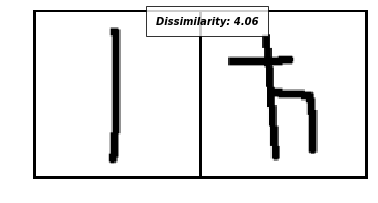

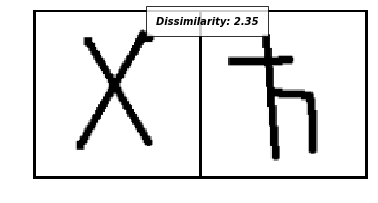

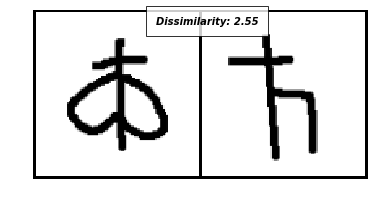

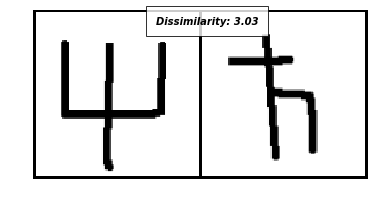

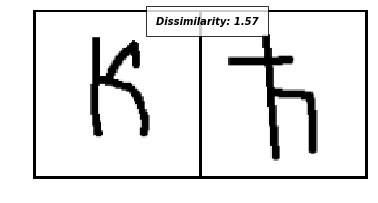

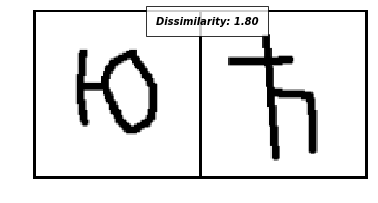

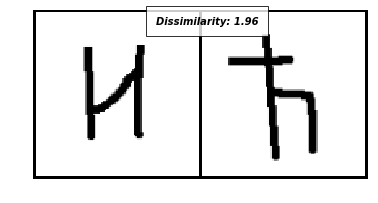

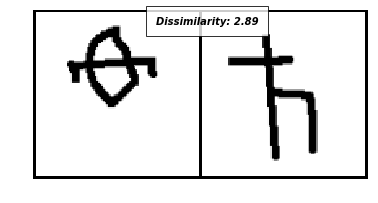

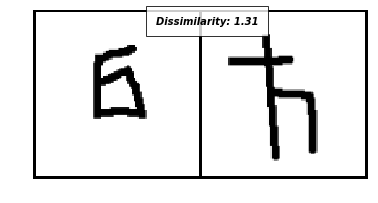

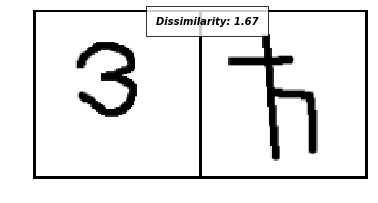

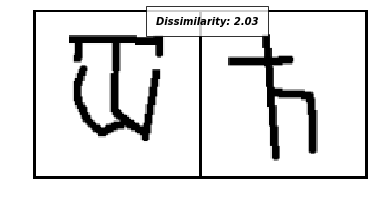

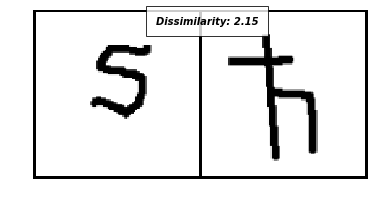

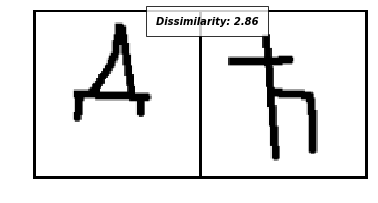

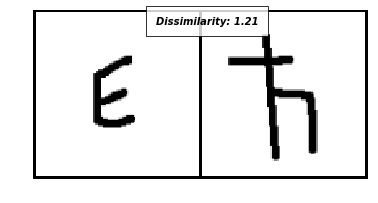

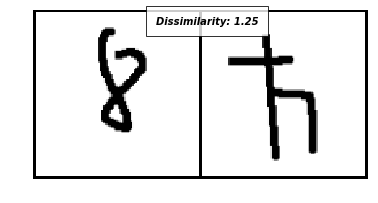

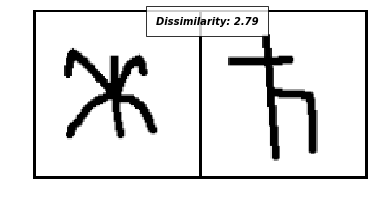

 run 15 (error 95.0%)


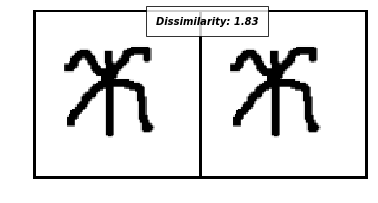

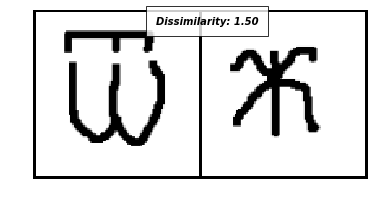

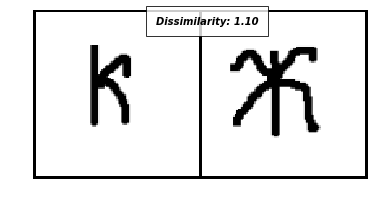

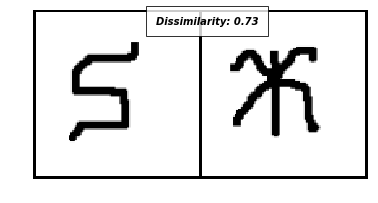

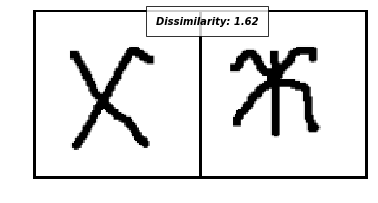

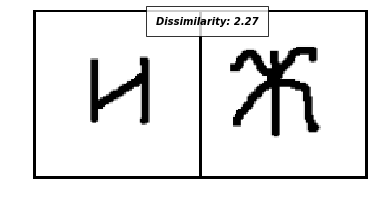

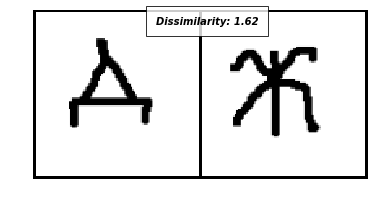

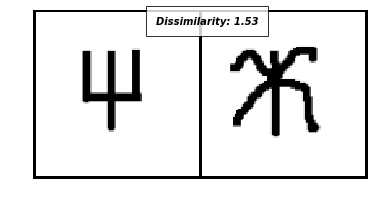

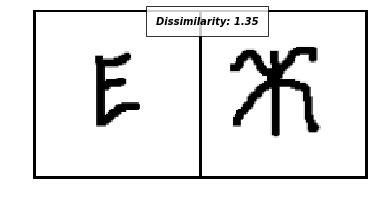

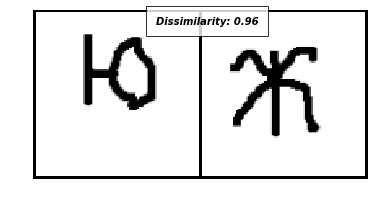

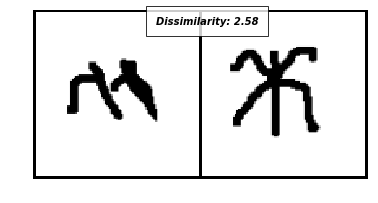

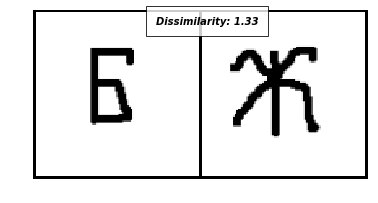

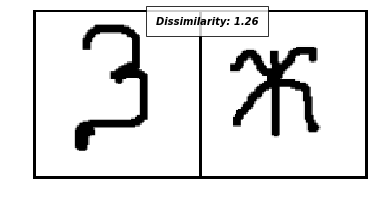

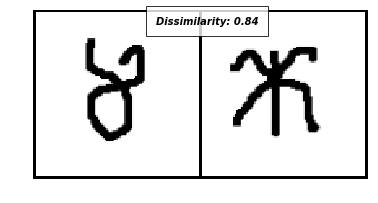

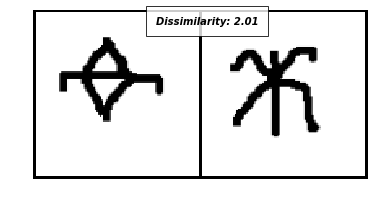

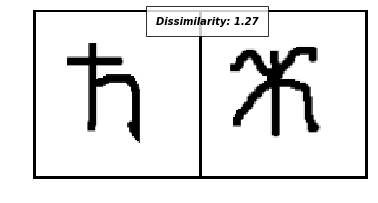

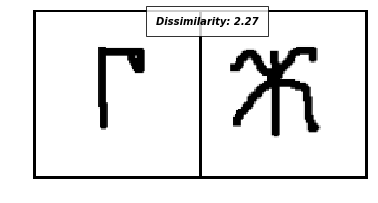

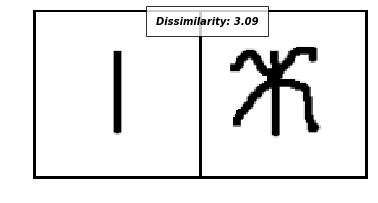

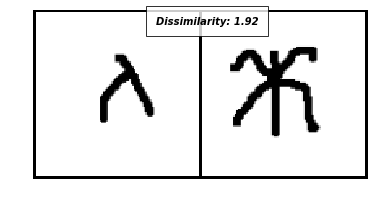

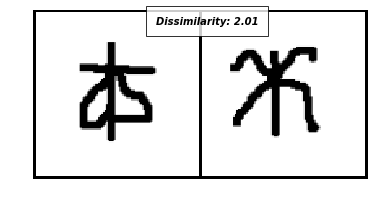

 run 16 (error 95.0%)


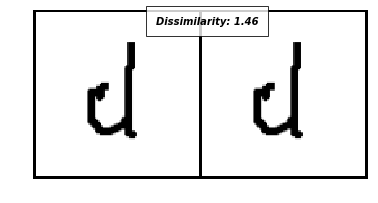

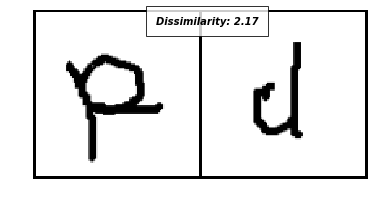

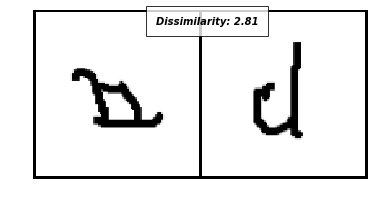

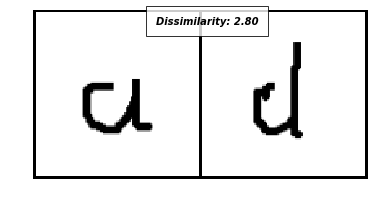

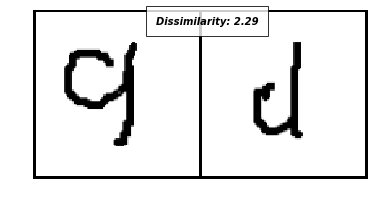

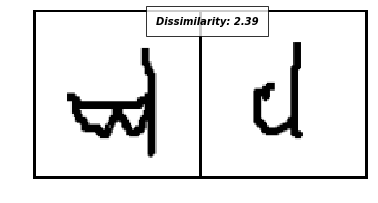

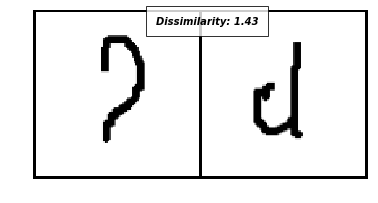

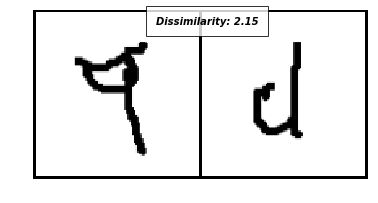

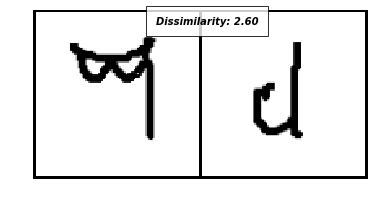

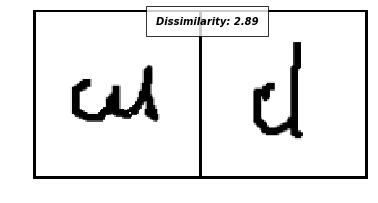

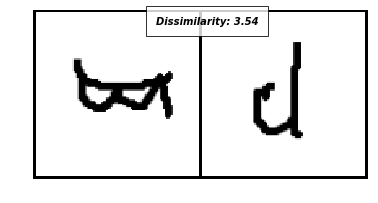

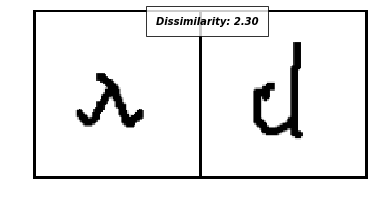

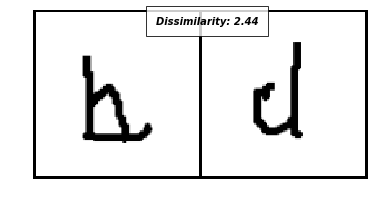

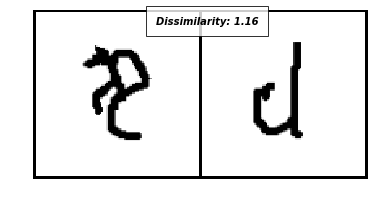

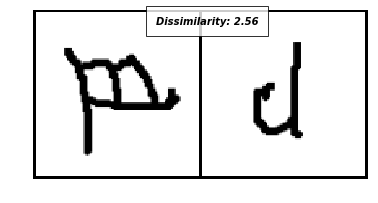

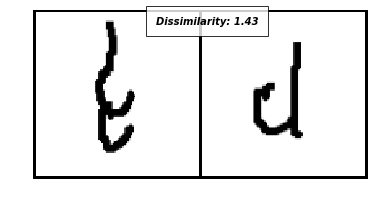

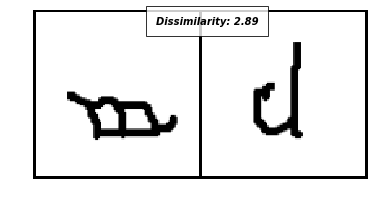

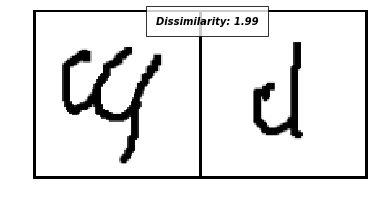

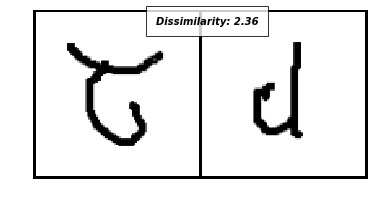

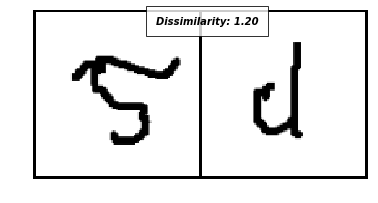

 run 17 (error 95.0%)


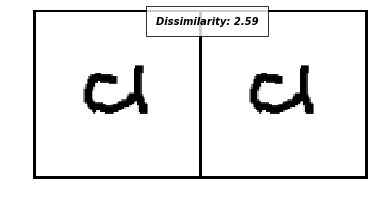

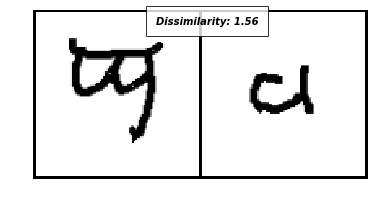

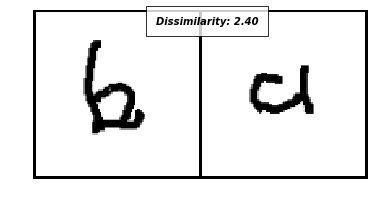

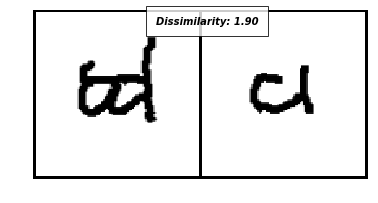

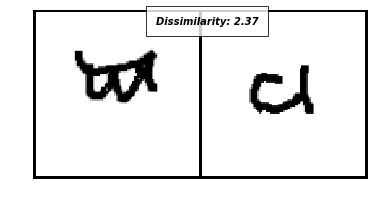

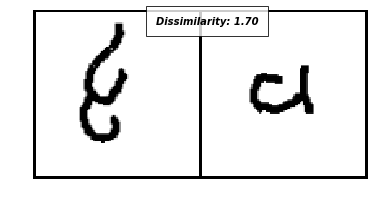

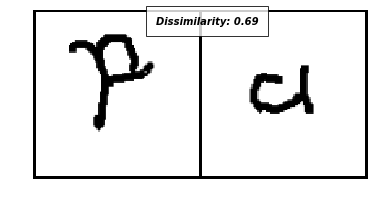

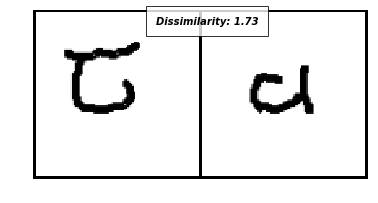

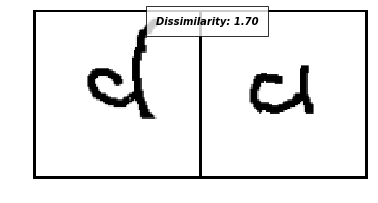

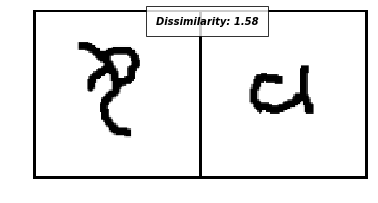

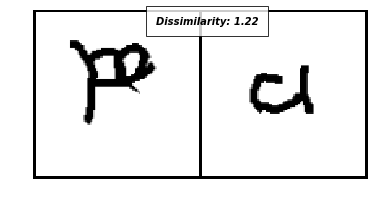

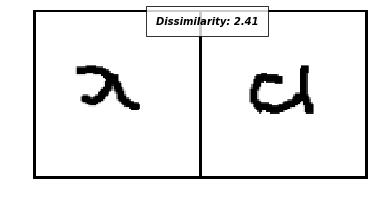

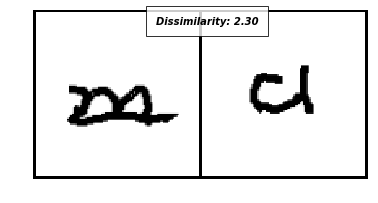

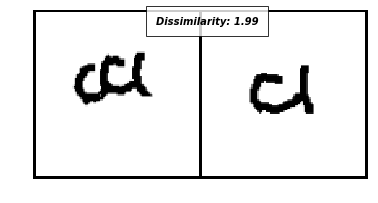

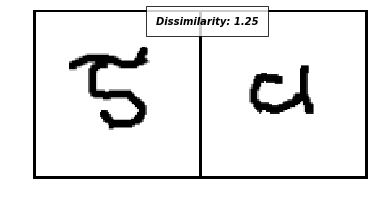

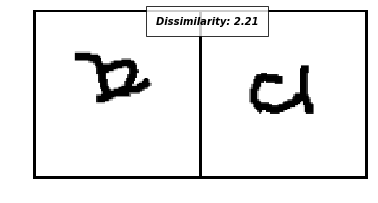

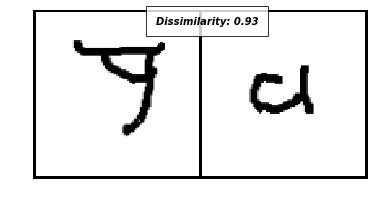

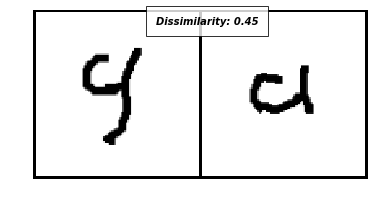

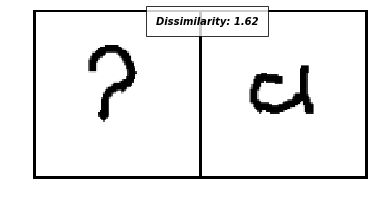

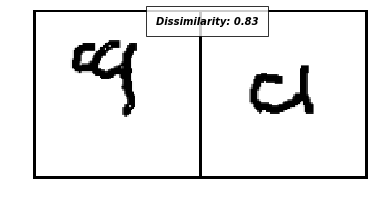

 run 18 (error 95.0%)


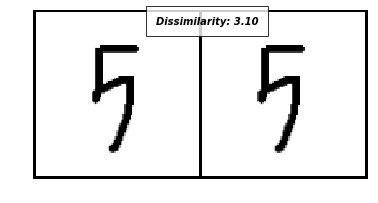

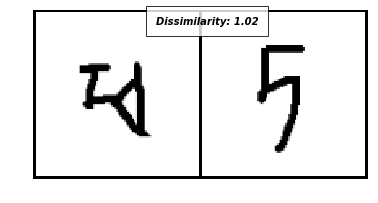

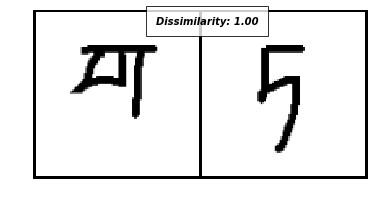

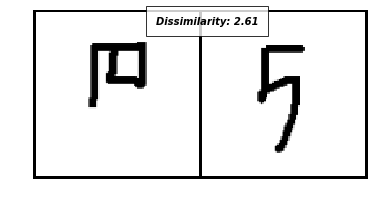

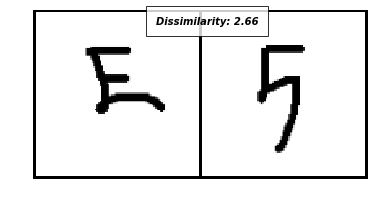

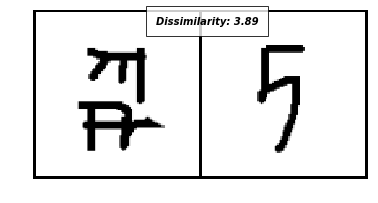

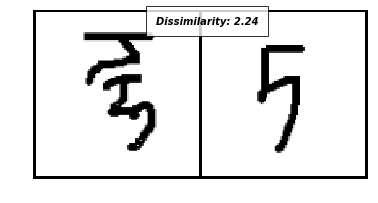

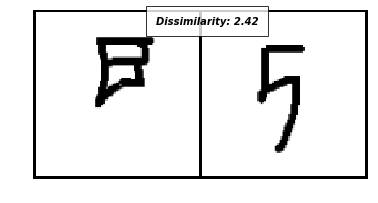

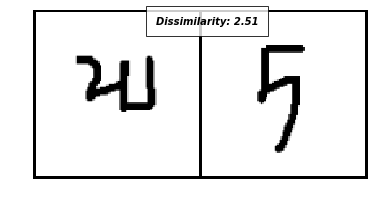

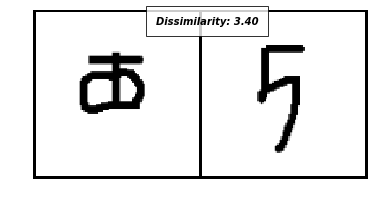

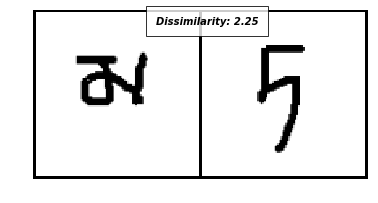

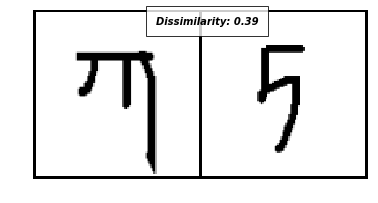

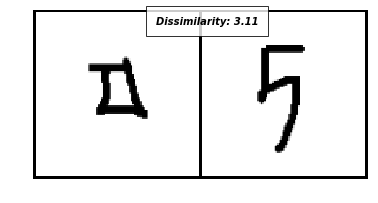

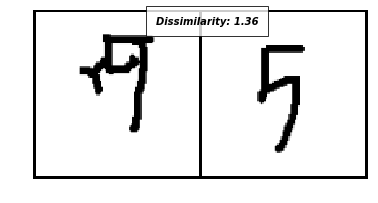

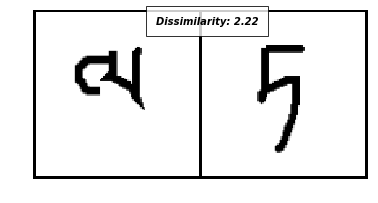

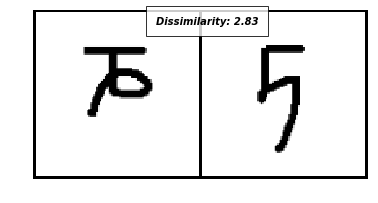

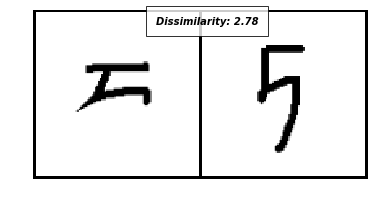

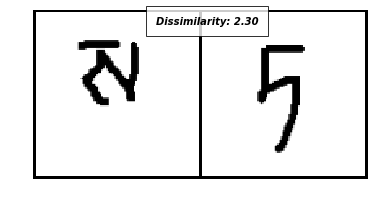

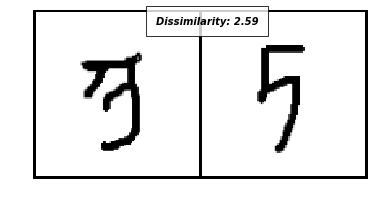

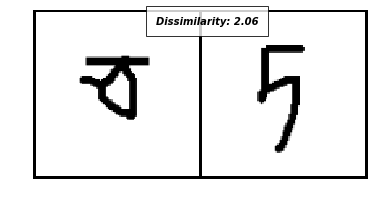

 run 19 (error 95.0%)


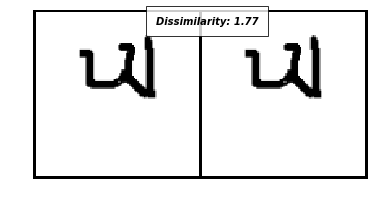

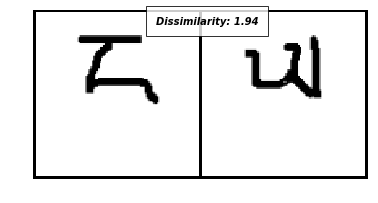

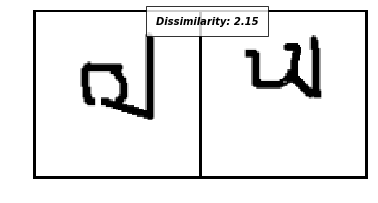

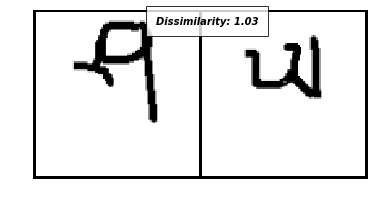

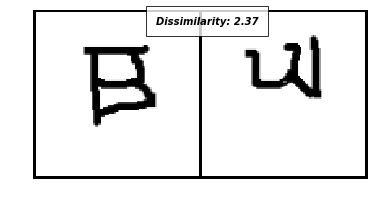

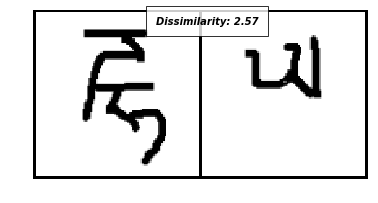

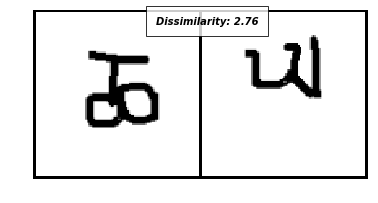

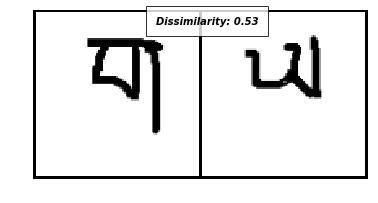

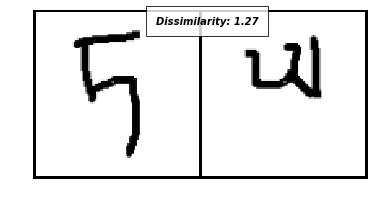

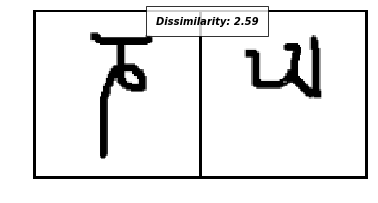

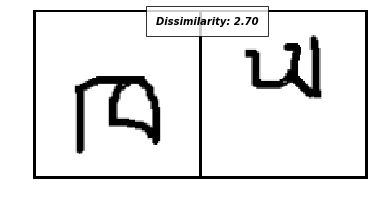

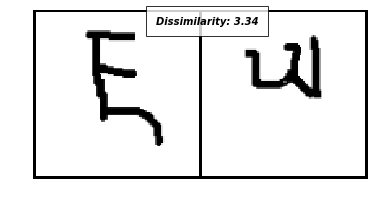

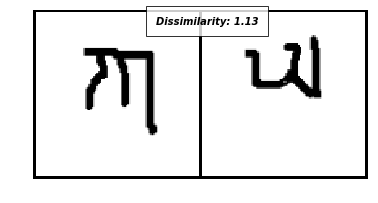

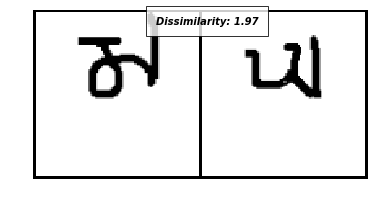

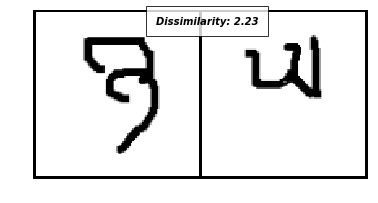

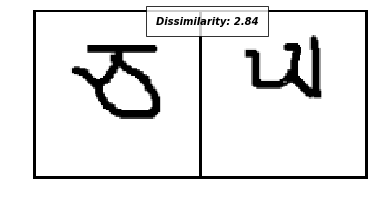

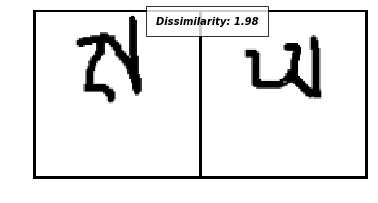

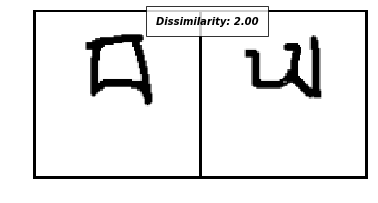

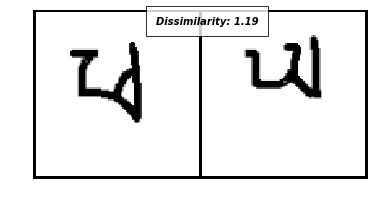

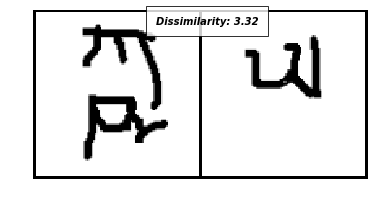

 run 20 (error 95.0%)
 average error 95.0%


In [65]:
if __name__ == "__main__":
    print 'One-shot classification demo with Modified Hausdorff Distance'
    perror = np.zeros(nrun)
    for r in range(1,nrun+1):
        rs = str(r)
        if len(rs)==1:
            rs = '0' + rs
        perror[r-1] = classification_run('run'+rs, LoadImgs, Distance, 'cost')
        print " run " + str(r) + " (error " + str(perror[r-1] ) + "%)"
    total = np.mean(perror)
    print " average error " + str(total) + "%"